In [1]:
!pip install bs4
!pip install shapely

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

from bs4 import BeautifulSoup

url = 'https://lawcenter.giffords.org/scorecard/#rankings'

#Make a get request to retrieve the page
html_page = requests.get(url) 

#Pass the page contents to beautiful soup for parsing
soup = BeautifulSoup(html_page.content, 'html.parser') 

# States use the 'strong' tag
tables = soup.find_all('table')

In [3]:
# Create Dictionary for parsing values
state_rankings_2018 = {'Year': [], 'State':[], 'Grade': [], 'State_GPA': [], 'Gun_Death_Rate': []}

# Define grading scale
grades = {'A':4, 'A-': 3.7, 
          'B+': 3.3, 'B': 3, 'B-':2.7, 
          'C+': 2.3, 'C': 2, 'C-': 1.7, 
          'D+': 1.3, 'D': 1, 'D-': .7, 'F': 0}

# Iterate through each row of table and save to dictionary
for i in range(50):
    state_rankings_2018['Year'].append(2017)
    state_rankings_2018['State'].append(tables[0].find_all('td')[5 * i + 1].text)
    state_rankings_2018['Grade'].append(tables[0].find_all('td')[5 * i + 2].text)
    state_rankings_2018['State_GPA'].append(grades[state_rankings_2018['Grade'][-1]])
    state_rankings_2018['Gun_Death_Rate'].append(float(tables[0].find_all('td')[5 * i + 4].text))

# Create dataframe from dictionary
pd.DataFrame.from_dict(state_rankings_2018).to_csv('giffords/giffords_2018.csv')

#  Preview dataframe
giffords_df_2018 = pd.read_csv('giffords/giffords_2018.csv', index_col=0)
giffords_df_2018.head()

,Year,State,Grade,State_GPA,Gun_Death_Rate
0,2017,Alabama,F,0.0,22.9
1,2017,Alaska,F,0.0,24.5
2,2017,Arizona,F,0.0,15.7
3,2017,Arkansas,F,0.0,20.2
4,2017,California,A,4.0,7.8


R-Square: 0.6207020030717032
Intercept: 17.318130935828243
Slope: -2.935286215916856
P-Value: 1.1297652905320656e-11


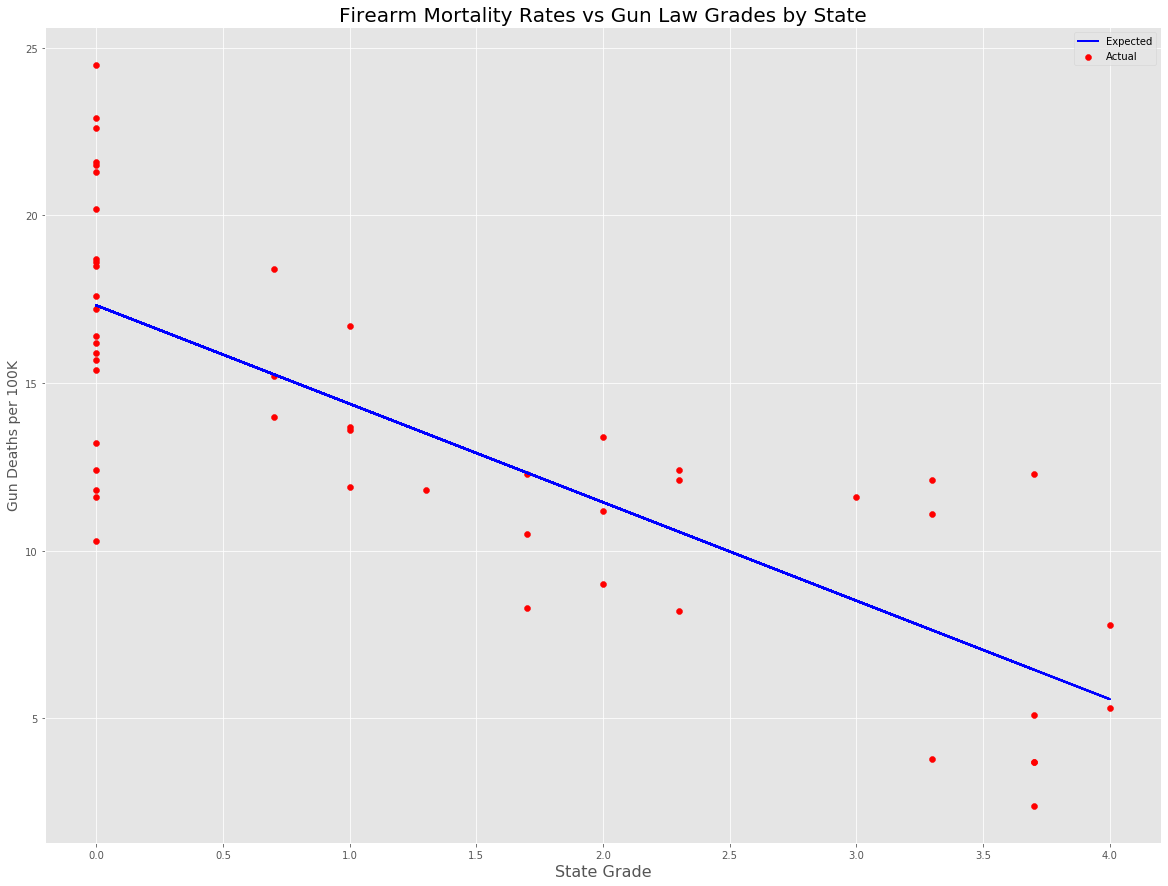

In [4]:
import statsmodels.formula.api as smf
import sklearn as sk
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.style.use('ggplot')

# Set define variables and build model
f = 'Gun_Death_Rate~State_GPA'
model = smf.ols(formula=f, data=giffords_df_2018).fit()

# Display results
print(f'R-Square: {model.rsquared}') 
print(f'Intercept: {model.params[0]}')
print(f'Slope: {model.params[1]}')
print(f'P-Value: {model.pvalues[1]}')

# Plot regression
y_pred = model.predict()
plt.figure(figsize=(20, 15))
plt.title('Firearm Mortality Rates vs Gun Law Grades by State', fontsize=20)
plt.xlabel('State Grade', fontsize=16)
plt.ylabel('Gun Deaths per 100K', fontsize=14)
plt.scatter(giffords_df_2018['State_GPA'], giffords_df_2018['Gun_Death_Rate'], marker='o', label='Actual', color='r')
plt.plot(giffords_df_2018['State_GPA'], y_pred, color='b', lw=2, label='Expected')
plt.legend()
plt.show()

In [5]:
# Set categories for downloading data
# Same process will be required for homicide & suicide data
cats = ['homicide', 'suicide']

def get_cdc_data(cat):
    
    # Define columns to import
    cols = ['State', 'Year', 'Deaths', 'Population', 'Age Adjusted Rate']
    
    # Set variables for csv paths to download
    a = f'cdc_data/{cat}/all_1979-1998.txt'
    b = f'cdc_data/{cat}/all_1999-2016.txt'
    gun_a = f'cdc_data/{cat}/firearm_1979-1998.txt'
    gun_b = f'cdc_data/{cat}/firearm_1999-2016.txt'
    
    # Save data to separate dataframes
    df_a = pd.read_csv(a, sep='\t', usecols=cols).dropna()
    df_b = pd.read_csv(b, sep='\t', usecols=cols).dropna()
    gun_df_a = pd.read_csv(gun_a, sep='\t', usecols=cols).dropna()
    gun_df_b = pd.read_csv(gun_b, sep='\t', usecols=cols).dropna()
    
    # Combine dataframes to capture full date range
    df = df_a.append(df_b).reset_index(drop=True)
    gun_df = gun_df_a.append(gun_df_b).reset_index(drop=True)
    
    
    
    # Rename target column to reflect target
    cat_col = f'{cat.title()} Rate'
    df = df.rename(columns={'Age Adjusted Rate': cat_col})
    
    # Replace "suppressed" data with 10
    df[cat_col] = df[cat_col].astype('str')
    df['Year'] = df['Year'].astype('int')
    df = df[df.Year>=1991].reset_index(drop=True)
    df['Deaths'] = df['Deaths'].replace('Suppressed', '10').astype('int')
    
    # Create uniform index based on state & year
    df['State-Year'] = df['State'] + ' ' + df['Year'].astype('str')
    df = df.set_index('State-Year')
    
    # Repeat last 3 steps for gun-related target
    
    # Rename target column to reflect target
    gun_cat_col = f'Gun {cat.title()} Rate'
    gun_df = gun_df.rename(columns={'Age Adjusted Rate': gun_cat_col})
    
    # Replace "suppressed" data with 10
    gun_df[gun_cat_col] = gun_df[gun_cat_col].astype('str')
    gun_df['Year'] = gun_df['Year'].astype('int')
    gun_df = gun_df[gun_df.Year>=1991].reset_index(drop=True)
    gun_df['Deaths'] = gun_df['Deaths'].replace('Suppressed', '10').astype('int')
    
    # Create uniform index based on state & year
    gun_df['State-Year'] = gun_df['State'] + ' ' + gun_df['Year'].astype('str')
    gun_df = gun_df.set_index('State-Year')
    
    # Remove "unreliable" flag in each dataframe
    for ix in df.index:
        if ('Unreliable' in df.loc[ix, cat_col]) or (df.loc[ix, cat_col] == 'Suppressed'):
            deaths = df.loc[ix, 'Deaths']
            pop = df.loc[ix, 'Population']
            df.loc[ix, cat_col] = np.round(100000 * deaths/pop, 1)
            
    for ix in gun_df.index:
        if ('Unreliable' in gun_df.loc[ix, gun_cat_col]) or (gun_df.loc[ix, gun_cat_col] == 'Suppressed'):
            deaths = gun_df.loc[ix, 'Deaths']
            pop = gun_df.loc[ix, 'Population']
            gun_df.loc[ix, gun_cat_col] = np.round(100000 * deaths/pop, 1)
    
    # Combine dataframes
    final_df = df.join(gun_df[gun_cat_col]).drop(['Deaths', 'Population'], axis=1)
    for col in [cat_col, gun_cat_col]:
        final_df[col] = final_df[col].astype('float')
    
    # Create column to calculate ratio between target and gun-related target rates
    final_df[f'Other {cat.title()}'] = final_df[cat_col] - final_df[gun_cat_col]
    final_df[f'{cat.title()} Pct Difference'] = final_df[f'Other {cat.title()}'] / final_df[gun_cat_col]
    return final_df    

In [6]:
# Create single dataframe combining homicide & suicide data
homicide_df = get_cdc_data('homicide')
suicide_df = get_cdc_data('suicide')
gun_mortality = homicide_df.join(suicide_df[suicide_df.columns[2:]])
gun_mortality.head()

,State,Year,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference
State-Year,,,,,,,,,,
Alabama 1991,Alabama,1991,13.8,10.0,3.8,0.380000,13.2,10.4,2.8,0.269231
Alabama 1992,Alabama,1992,12.7,9.1,3.6,0.395604,12.6,9.5,3.1,0.326316
Alabama 1993,Alabama,1993,13.4,9.5,3.9,0.410526,13.0,10.1,2.9,0.287129
Alabama 1994,Alabama,1994,13.7,9.9,3.8,0.383838,12.6,9.4,3.2,0.340426
Alabama 1995,Alabama,1995,12.0,9.1,2.9,0.318681,13.0,9.9,3.1,0.313131


In [7]:
cols = ['State', 'Year', 'Deaths', 'Population', 'Age Adjusted Rate']

accident_a = pd.read_csv('cdc_data/accidents/firearm_1979-1998.txt', sep='\t', usecols=cols).dropna()
accident_b = pd.read_csv('cdc_data/accidents/firearm_1999-2016.txt', sep='\t', usecols=cols).dropna()
accident_df = accident_a.append(accident_b)

accident_df = accident_df.rename(columns={'Age Adjusted Rate': 'Gun Accident Rate'})
accident_df['Year'] = accident_df['Year'].astype('int')
accident_df = accident_df[accident_df.Year>=1991].reset_index(drop=True)

accident_df['Deaths'] = accident_df['Deaths'].replace('Suppressed', '10').astype('int')
accident_df['State-Year'] = accident_df['State'] + ' ' + accident_df['Year'].astype('str')
accident_df = accident_df.set_index('State-Year')

for ix in accident_df.index:
    if ('Unreliable' in accident_df.loc[ix, 'Gun Accident Rate']) or (accident_df.loc[ix, 'Gun Accident Rate'] == 'Suppressed'):
        deaths = accident_df.loc[ix, 'Deaths']
        pop = accident_df.loc[ix, 'Population']
        accident_df.loc[ix, 'Gun Accident Rate'] = np.round(100000 * deaths/pop, 1)

accident_df['Gun Accident Rate'] = accident_df['Gun Accident Rate'].astype('float')

gun_mortality = gun_mortality.join(accident_df['Gun Accident Rate'])
gun_mortality.head()

,State,Year,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,Gun Accident Rate
State-Year,,,,,,,,,,,
Alabama 1991,Alabama,1991,13.8,10.0,3.8,0.380000,13.2,10.4,2.8,0.269231,1.5
Alabama 1992,Alabama,1992,12.7,9.1,3.6,0.395604,12.6,9.5,3.1,0.326316,1.7
Alabama 1993,Alabama,1993,13.4,9.5,3.9,0.410526,13.0,10.1,2.9,0.287129,2.0
Alabama 1994,Alabama,1994,13.7,9.9,3.8,0.383838,12.6,9.4,3.2,0.340426,1.8
Alabama 1995,Alabama,1995,12.0,9.1,2.9,0.318681,13.0,9.9,3.1,0.313131,1.9


In [8]:
# Get results for all other years
state_rankings = {'Year':[], 'State':[], 'Grade':[], 'State Grade':[]}

for yr in range(2015, 2018):
    url = f'https://lawcenter.giffords.org/scorecard{int(yr)}/#rankings'

    #Make a get request to retrieve the page
    html_page = requests.get(url) 

    #Pass the page contents to beautiful soup for parsing
    soup = BeautifulSoup(html_page.content, 'html.parser') 

    # States use the 'strong' tag
    tables = soup.find_all('table')

    # Define grading scale
    grades = {'A':4, 'A-': 3.7, 
              'B+': 3.3, 'B': 3, 'B-':2.7, 
              'C+': 2.3, 'C': 2, 'C-': 1.7, 
              'D+': 1.3, 'D': 1, 'D-': .7, 'F': 0}

    # Iterate through each row of table and save to dictionary
    for i in range(50):
        state_rankings['Year'].append(yr-1)
        state_rankings['State'].append(tables[0].find_all('td')[5 * i + 1].text.strip())
        state_rankings['Grade'].append(tables[0].find_all('td')[5 * i + 2].text.strip())
        state_rankings['State Grade'].append(grades[state_rankings['Grade'][-1]])

# Create dataframe from dictionary
pd.DataFrame.from_dict(state_rankings).to_csv('giffords/giffords.csv')


giffords_df = pd.read_csv('giffords/giffords.csv', index_col=0)
giffords_df['State-Year'] = giffords_df.State + ' ' + giffords_df.Year.astype('str')
giffords_df = giffords_df.set_index('State-Year').sort_index()
giffords_df.head(15)

,Year,State,Grade,State Grade
State-Year,,,,
Alabama 2014,2014,Alabama,F,0.0
Alabama 2015,2015,Alabama,F,0.0
Alabama 2016,2016,Alabama,F,0.0
Alaska 2014,2014,Alaska,F,0.0
Alaska 2015,2015,Alaska,F,0.0
Alaska 2016,2016,Alaska,F,0.0
Arizona 2014,2014,Arizona,F,0.0
Arizona 2015,2015,Arizona,F,0.0
Arizona 2016,2016,Arizona,F,0.0


In [9]:
# death_rates['Year'] = death_rates.Year.astype(int)
death_rates = gun_mortality[gun_mortality['Year'] >= 2014]
death_rates['Year'].unique()

array([2014, 2015, 2016])

In [10]:
df = giffords_df.join(death_rates[death_rates.columns[2:]])
# df = df.reset_index(drop=True)
df.head()

,Year,State,Grade,State Grade,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,Gun Accident Rate
State-Year,,,,,,,,,,,,,
Alabama 2014,2014,Alabama,F,0.0,8.1,6.4,1.7,0.265625,14.5,9.6,4.9,0.510417,0.6
Alabama 2015,2015,Alabama,F,0.0,10.2,8.5,1.7,0.200000,14.9,10.4,4.5,0.432692,0.4
Alabama 2016,2016,Alabama,F,0.0,11.8,9.8,2.0,0.204082,15.6,10.7,4.9,0.457944,0.4
Alaska 2014,2014,Alaska,F,0.0,4.7,2.6,2.1,0.807692,22.1,15.4,6.7,0.435065,1.4
Alaska 2015,2015,Alaska,F,0.0,8.0,5.4,2.6,0.481481,26.9,16.5,10.4,0.630303,1.4


In [11]:
import urllib.request
url = 'https://github.com/ritvikmath/StarbucksStoreScraping/raw/master/us_states.geojson'

urllib.request.urlretrieve(url, 'national_data/us_states.geojson')

#manipulate complex shapes
from shapely.geometry import Polygon, MultiPolygon

#manipulate json objects
import json

#open up the US States Geojson
with open('us_states.geojson') as f:
    states = json.load(f)

#initialize a dictionary to store the state shape info
statePolygons = {}

#for each state ...
for stateInfo in states['features']:
    #get the state name
    stateName = stateInfo['properties']['NAME']
    
    #the state geography is either a Polygon (some shape) or a MultiPolygon (a collection of polygons)
    stateGeographyType = stateInfo['geometry']['type']
    
    #if it's a Polygon, convert the coordinates to a shapely Polygon object
    if stateGeographyType == 'Polygon':
        stateGeometry = Polygon(stateInfo['geometry']['coordinates'][0])
        
    #if its a MultiPolygon, convert each contained polygon into a shapely Polygon object ...
    #and then store the list of Polygons in a shapely MultiPolygon object
    elif stateGeographyType == 'MultiPolygon':
        polygonsInMultipolygon = [Polygon(p[0]) for p in stateInfo['geometry']['coordinates']]
        stateGeometry = MultiPolygon(polygonsInMultipolygon)
    
    #store the state geography info in the dictionary
    statePolygons[stateName] = stateGeometry

In [12]:
neighbors = {}

#for each state ...
for k1,v1 in statePolygons.items():
    neighbors[k1] = []
    #iterate over each other state
    for k2,v2 in statePolygons.items():
        #if the states touch, then add this state to the list of neighboring states
        if v1.touches(v2):
            neighbors[k1].append(k2)
            
for state in sorted(neighbors.keys())[:5]:
    print(f'{state}: {neighbors[state]}')

Alabama: ['Tennessee', 'Florida', 'Georgia', 'Mississippi']
Alaska: []
Arizona: ['Nevada', 'Utah', 'California', 'Colorado', 'New Mexico']
Arkansas: ['Tennessee', 'Texas', 'Louisiana', 'Mississippi', 'Missouri', 'Oklahoma']
California: ['Nevada', 'Arizona', 'Oregon']


In [13]:
# Create nested dictionaries to map grades to year and neighbor states
neighbor_grades = {}

for year in df.Year.unique():
    neighbor_grades[year] = {}
    
    for state in df.State.unique():
        # Default score is state score if no neighboring state (i.e. Alaska)
        default_score = df[(df.State==state) & (df.Year==year)]['State Grade'].values[0]
        scores = []
        
        for neighbor in neighbors[state]:
            
            if neighbor != 'District of Columbia':
                # Look up score based on year and state, add to scores list
                scores.append(df[(df.State==neighbor) & (df.Year==year)]['State Grade'].values[0])
        
        # Add appropriate score to dictionary; mean of scores or default score
        neighbor_grades[year][state] = np.mean(scores) if len(scores)>0 else default_score
        
neighbor_grades[2016]

{'Alabama': 0.175,
 'Alaska': 0.0,
 'Arizona': 1.4,
 'Arkansas': 0.11666666666666665,
 'California': 1.0,
 'Colorado': 0.14285714285714285,
 'Connecticut': 3.5666666666666664,
 'Delaware': 3.1333333333333333,
 'Florida': 0.0,
 'Georgia': 0.27999999999999997,
 'Hawaii': 3.7,
 'Idaho': 1.0,
 'Illinois': 0.82,
 'Indiana': 1.575,
 'Iowa': 1.3833333333333335,
 'Kansas': 0.75,
 'Kentucky': 0.9571428571428572,
 'Louisiana': 0.0,
 'Maine': 0.0,
 'Maryland': 1.5,
 'Massachusetts': 2.1399999999999997,
 'Michigan': 1.1333333333333335,
 'Minnesota': 0.85,
 'Mississippi': 0.175,
 'Missouri': 0.8375,
 'Montana': 0.0,
 'Nebraska': 0.6166666666666667,
 'Nevada': 1.2,
 'New Hampshire': 1.2333333333333334,
 'New Jersey': 2.9,
 'New Mexico': 0.4,
 'New York': 2.62,
 'North Carolina': 0.425,
 'North Dakota': 0.7666666666666666,
 'Ohio': 0.9400000000000001,
 'Oklahoma': 0.3333333333333333,
 'Oregon': 2.0,
 'Pennsylvania': 2.516666666666667,
 'Rhode Island': 3.7,
 'South Carolina': 0.35,
 'South Dakota': 0.

In [14]:
# Create ordered list of scores based on df.index
GPAs = []
for ix in df.index:
    state = df.loc[ix, 'State']
    year = df.loc[ix, 'Year']
    GPAs.append(neighbor_grades[year][state])

# Create new column from list
df['Neighbor State GPA'] = GPAs
df.head()

,Year,State,Grade,State Grade,Homicide Rate,Gun Homicide Rate,Other Homicide,Homicide Pct Difference,Suicide Rate,Gun Suicide Rate,Other Suicide,Suicide Pct Difference,Gun Accident Rate,Neighbor State GPA
State-Year,,,,,,,,,,,,,,
Alabama 2014,2014,Alabama,F,0.0,8.1,6.4,1.7,0.265625,14.5,9.6,4.9,0.510417,0.6,0.000
Alabama 2015,2015,Alabama,F,0.0,10.2,8.5,1.7,0.200000,14.9,10.4,4.5,0.432692,0.4,0.000
Alabama 2016,2016,Alabama,F,0.0,11.8,9.8,2.0,0.204082,15.6,10.7,4.9,0.457944,0.4,0.175
Alaska 2014,2014,Alaska,F,0.0,4.7,2.6,2.1,0.807692,22.1,15.4,6.7,0.435065,1.4,0.000
Alaska 2015,2015,Alaska,F,0.0,8.0,5.4,2.6,0.481481,26.9,16.5,10.4,0.630303,1.4,0.000


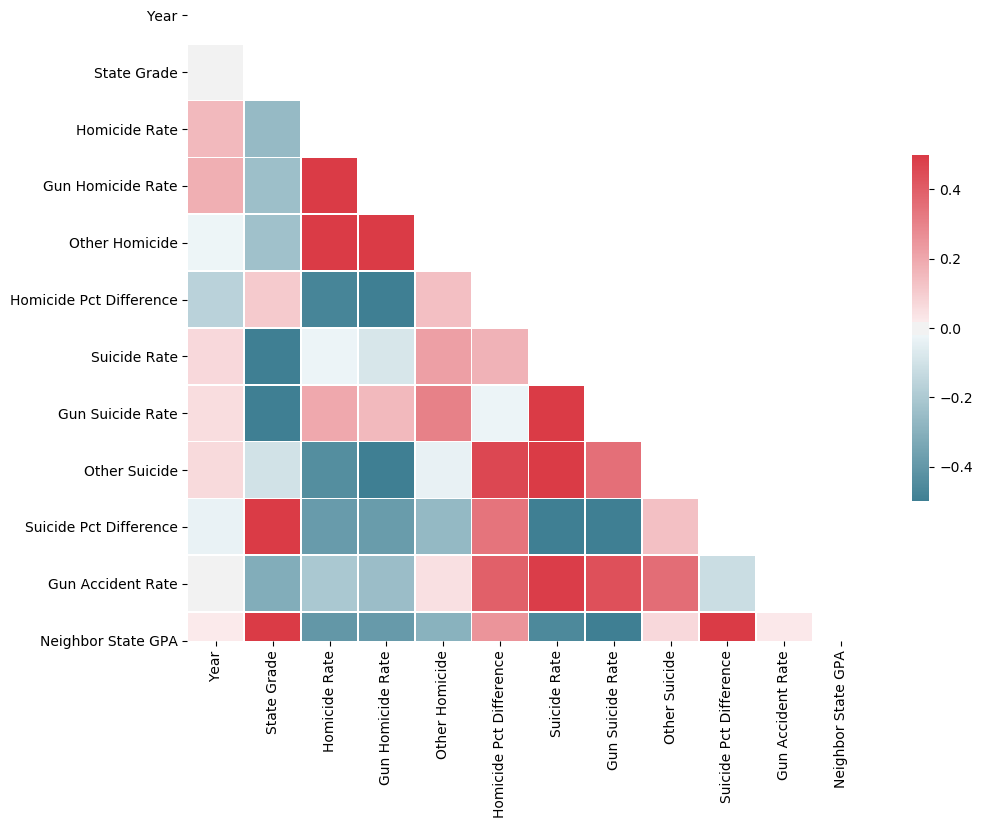

In [15]:
import seaborn as sns
import matplotlib as mpl

def coll_check(data, win=1, size=(11,9)):
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=win, vmin=-win, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

coll_check(df, win=.5)

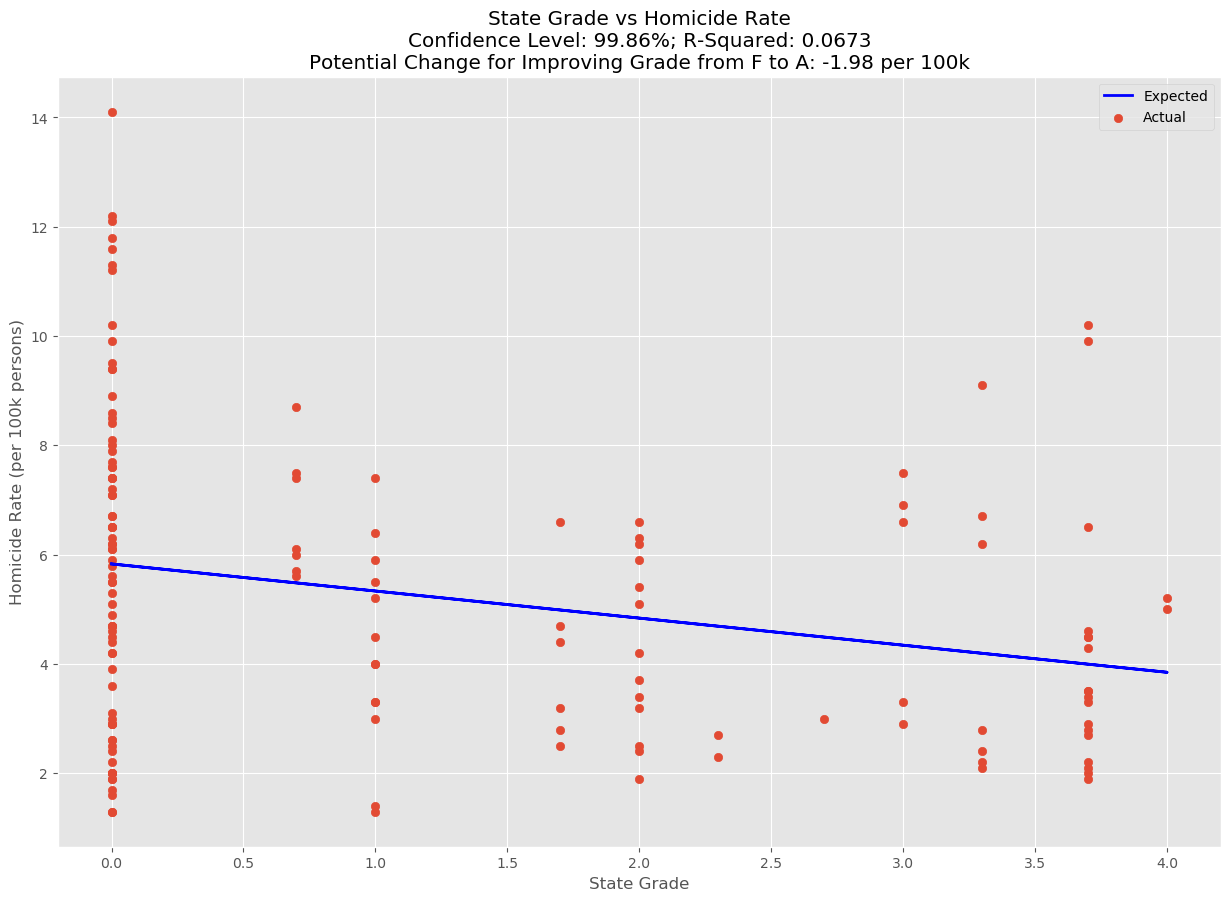

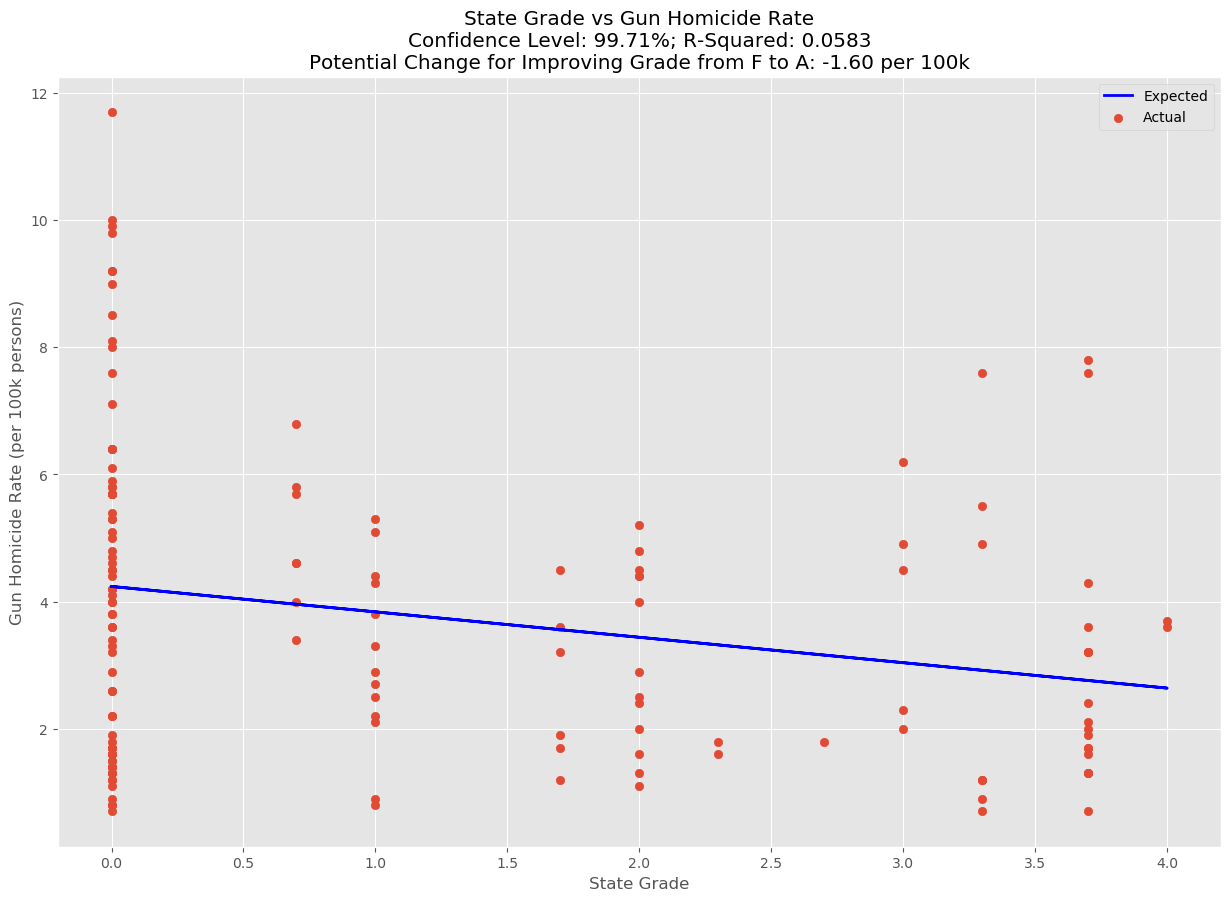

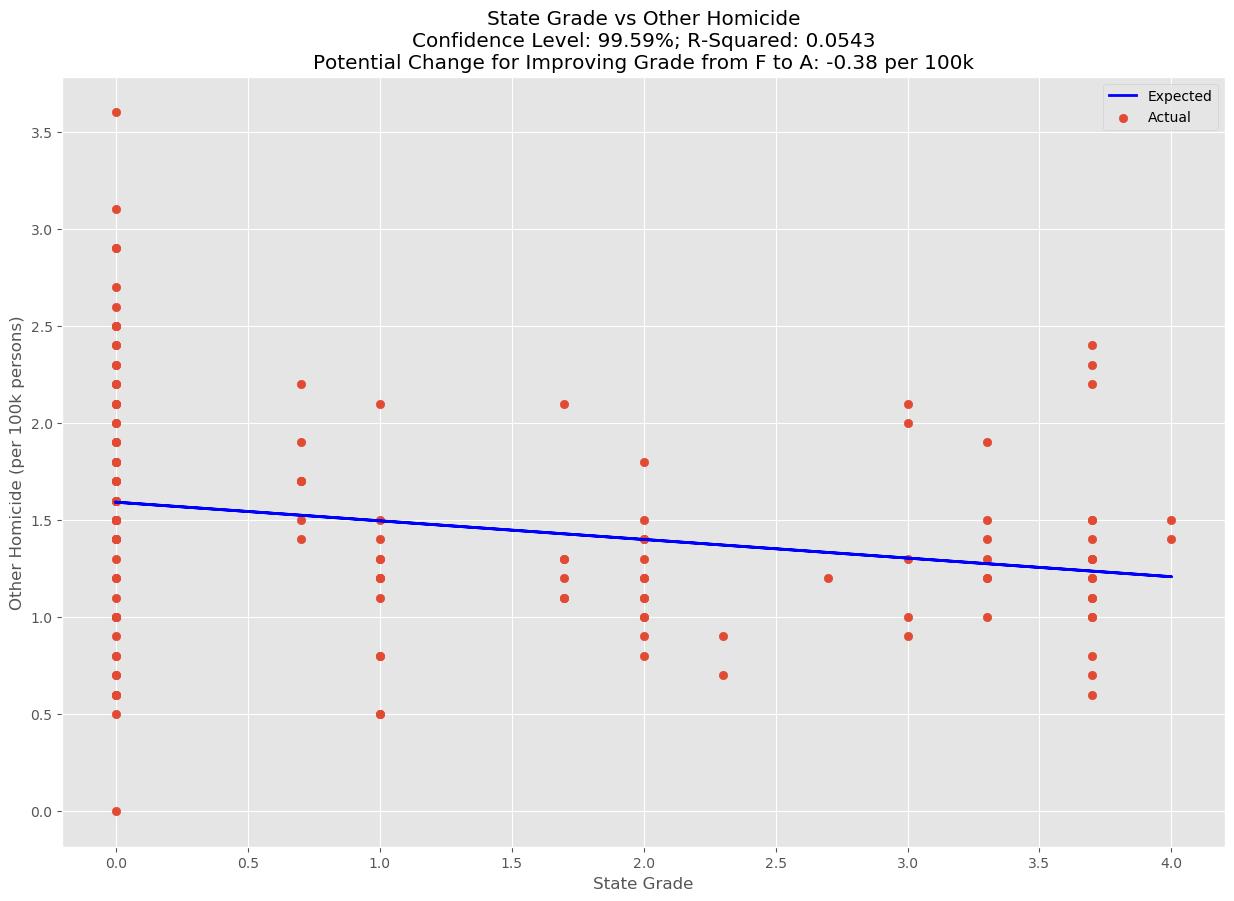

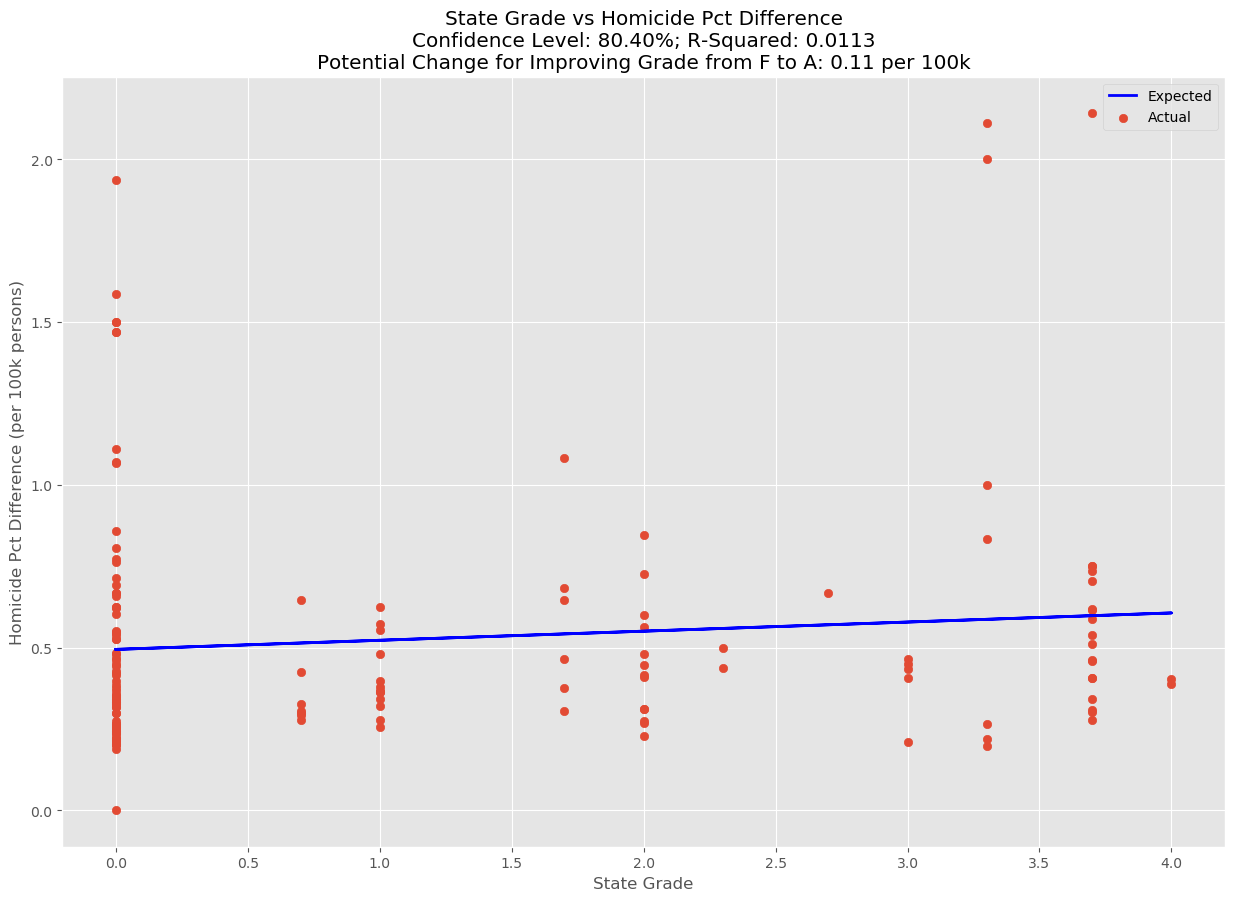

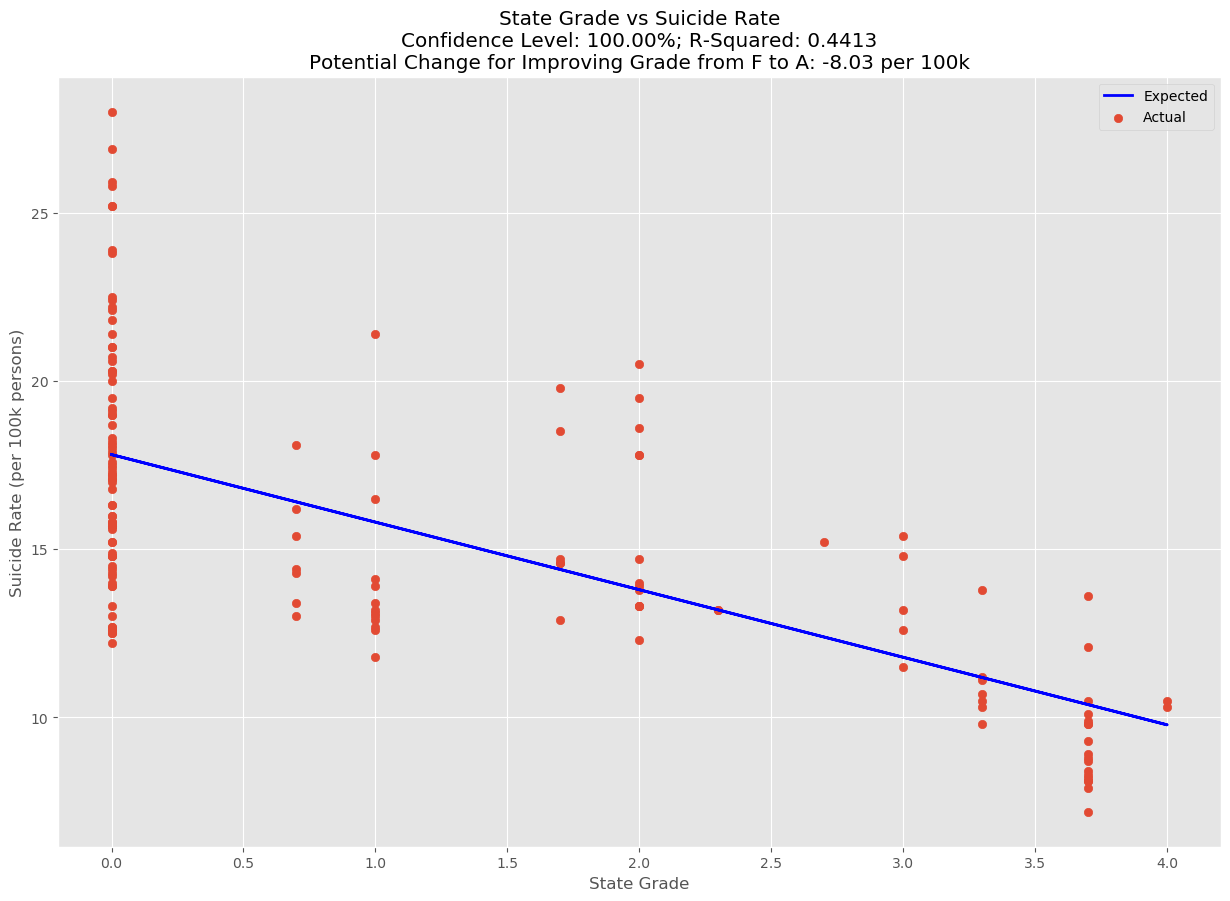

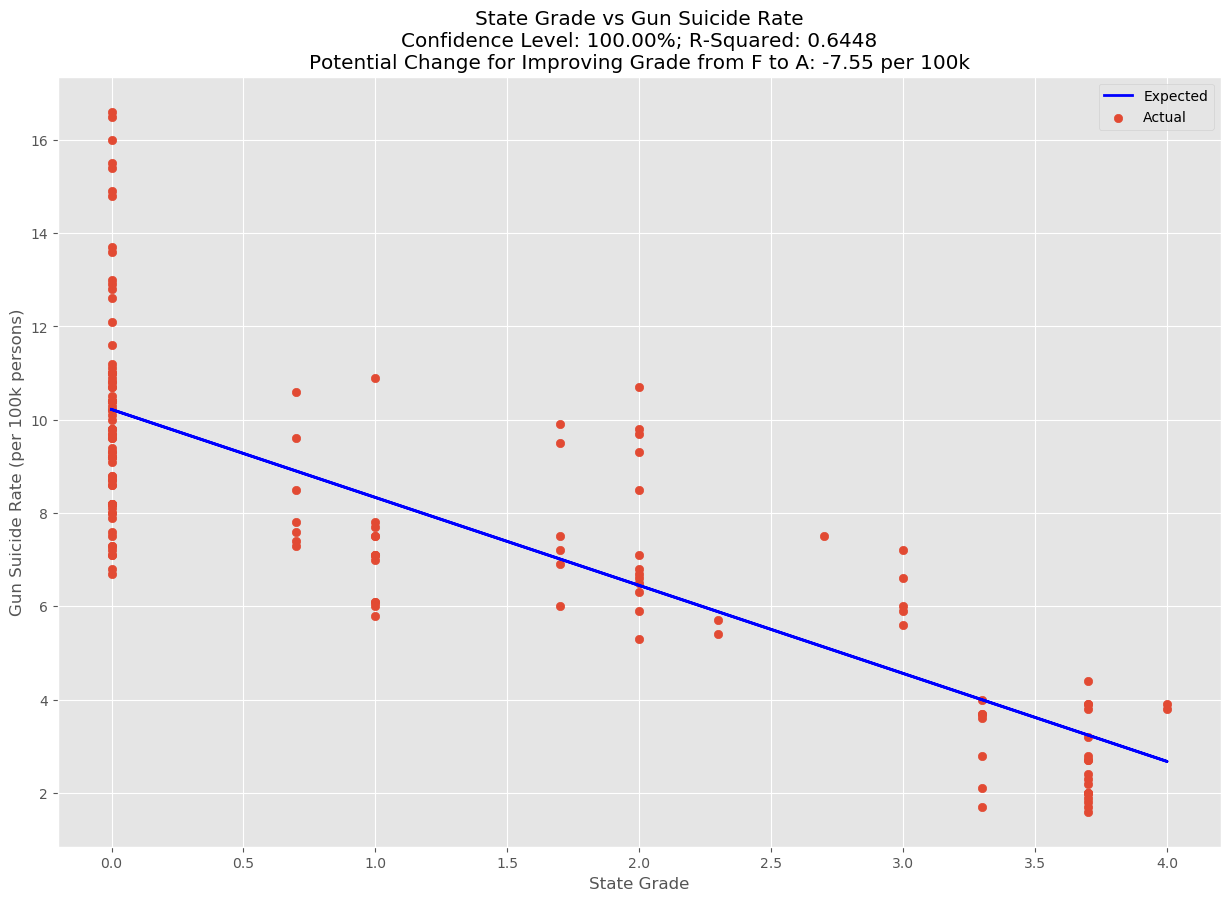

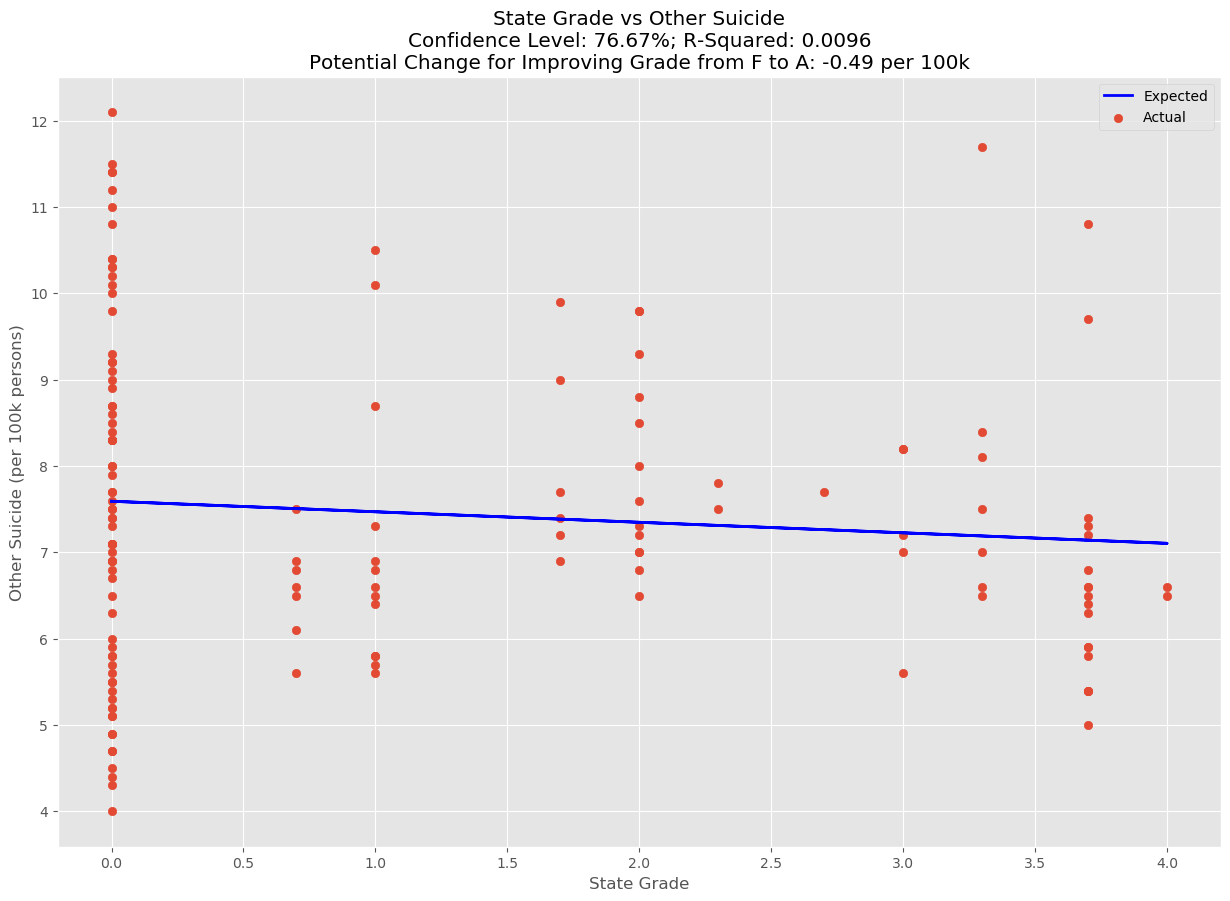

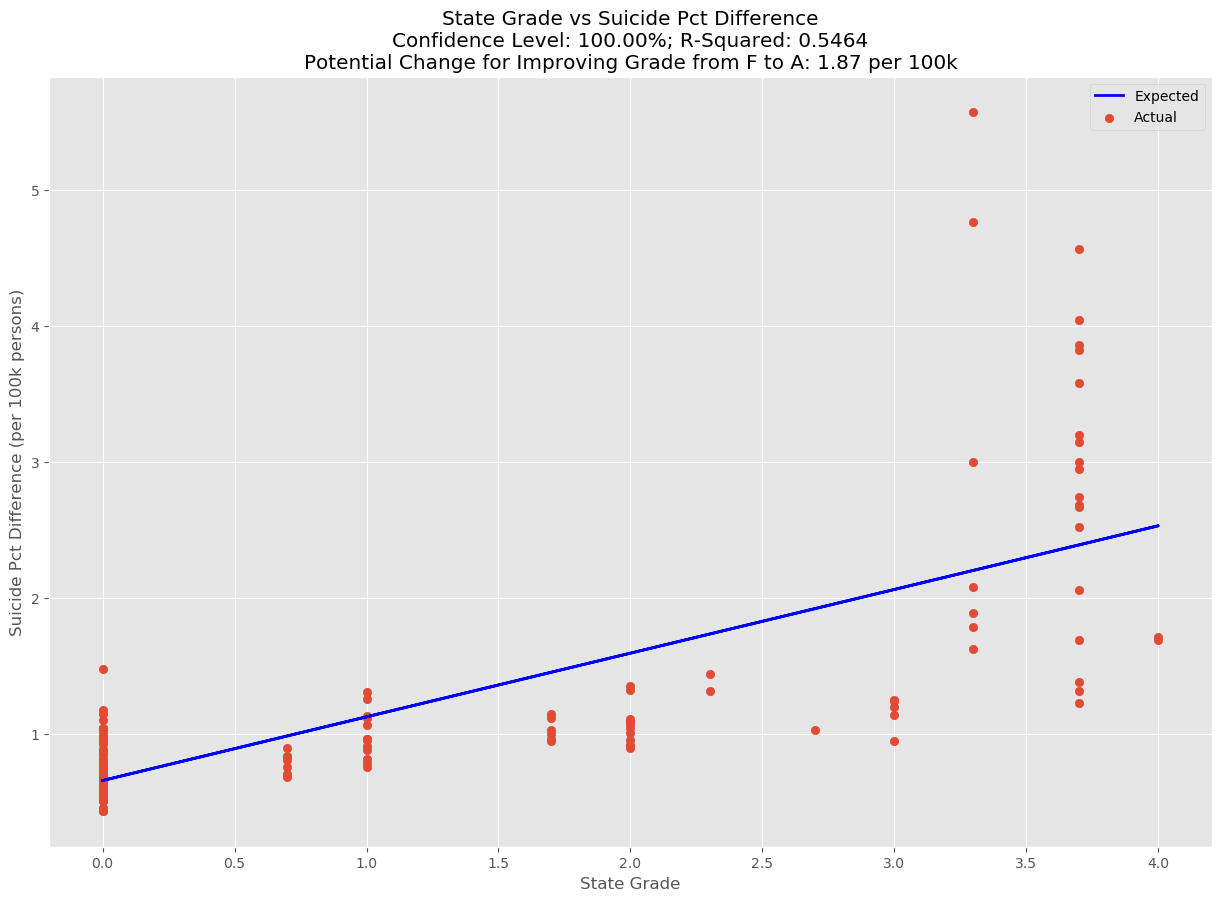

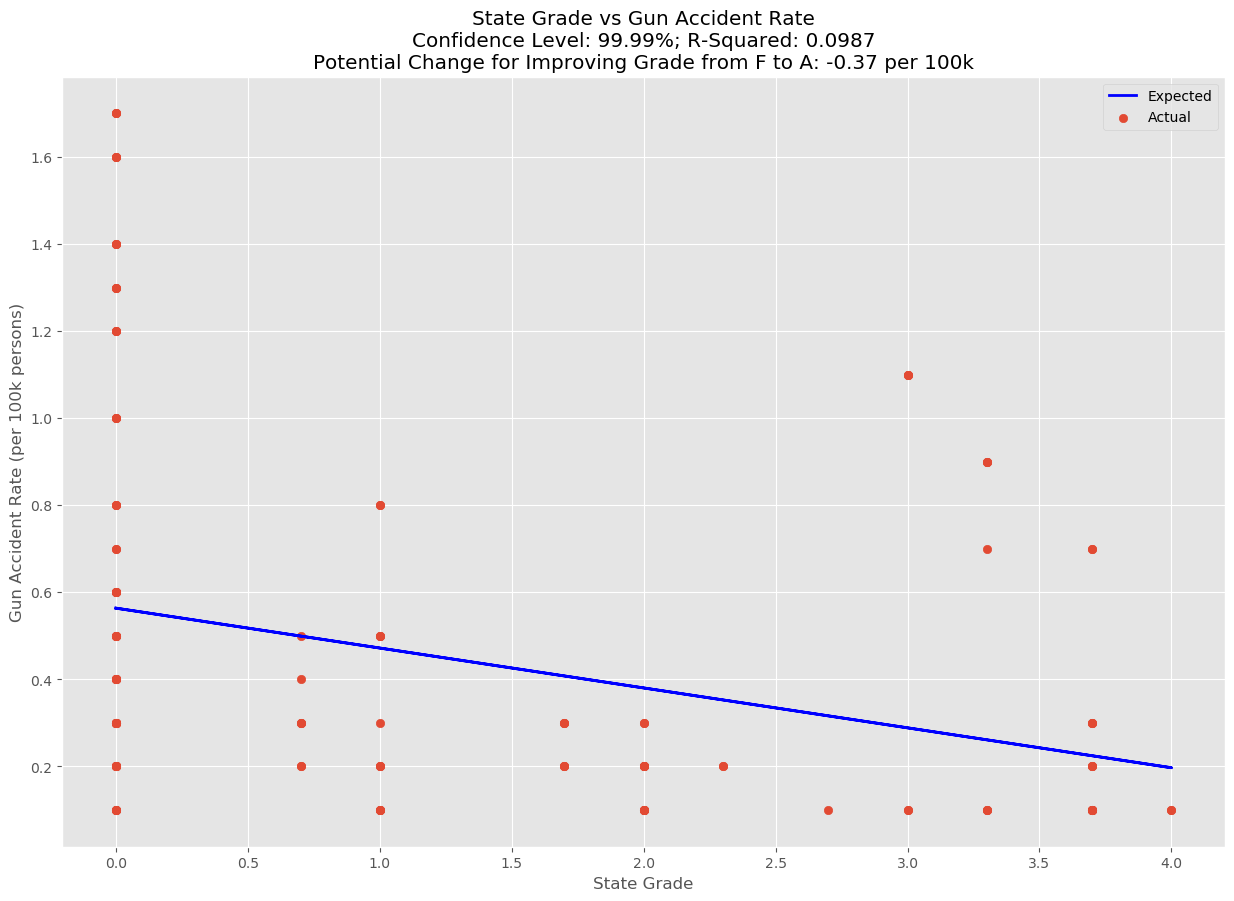

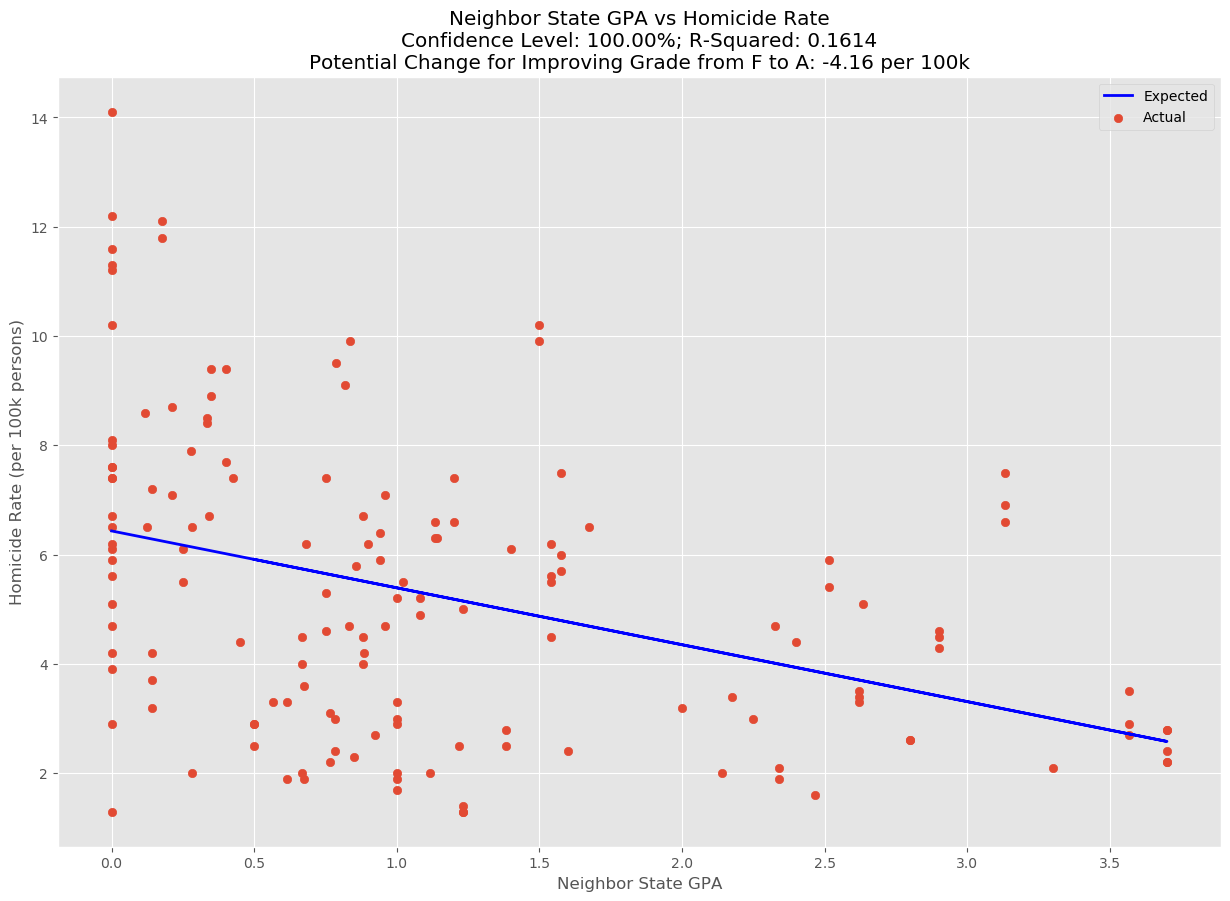

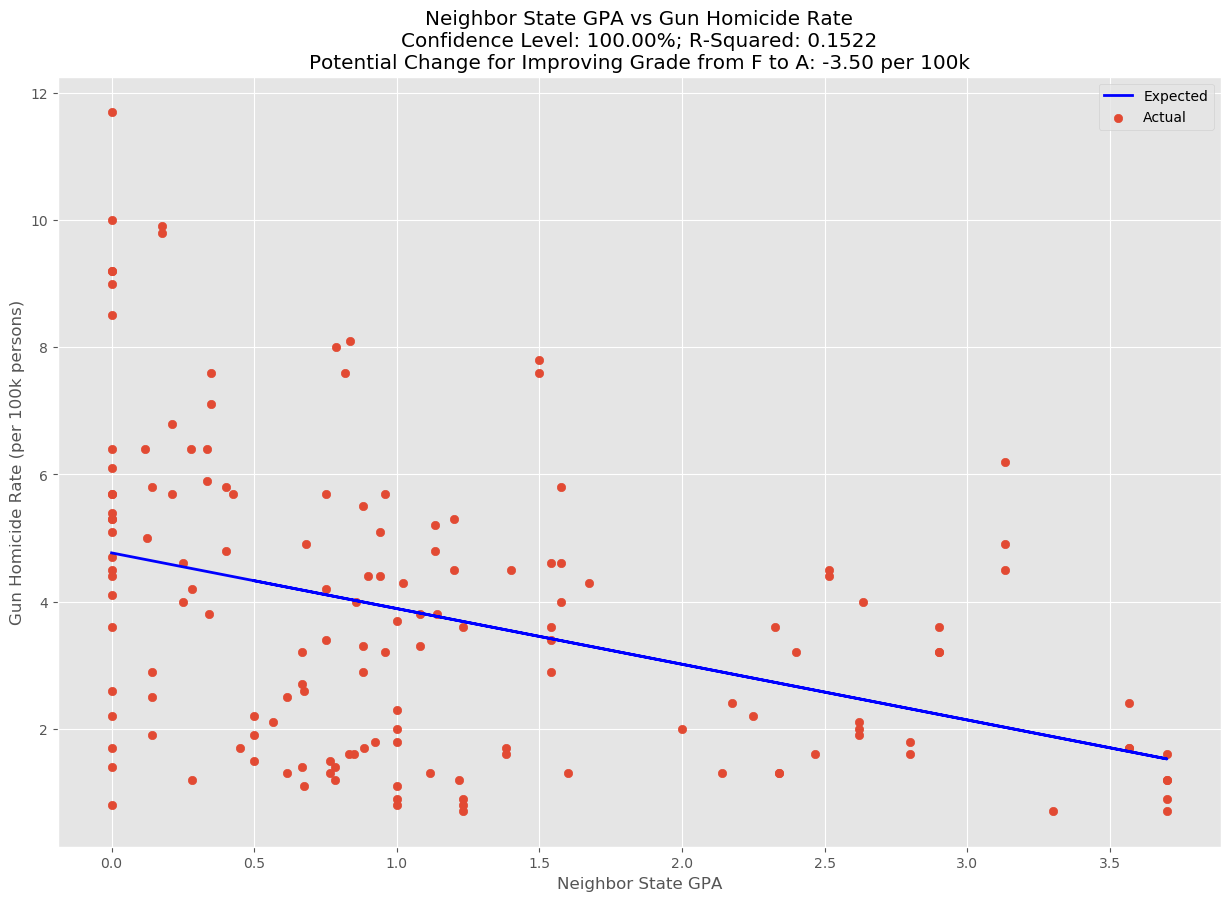

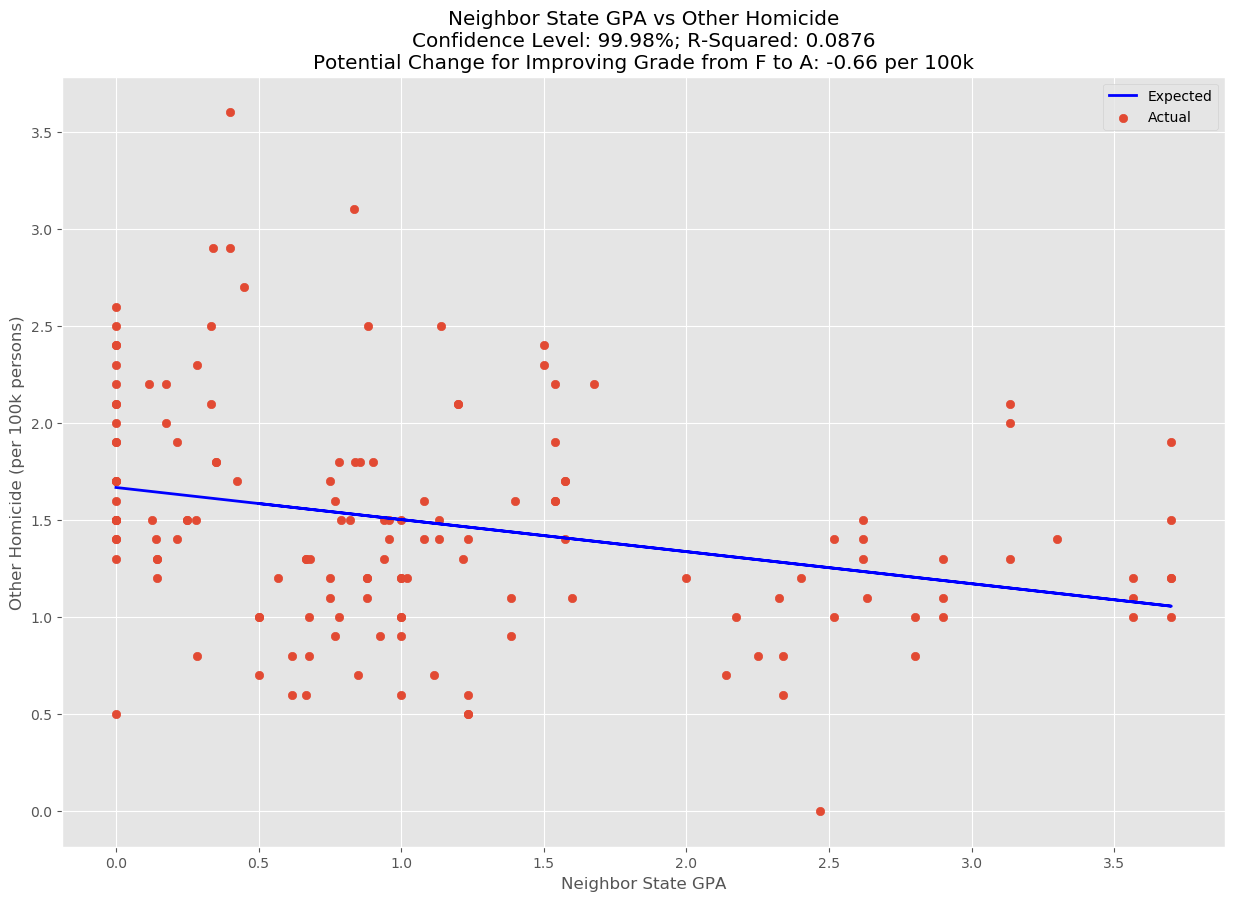

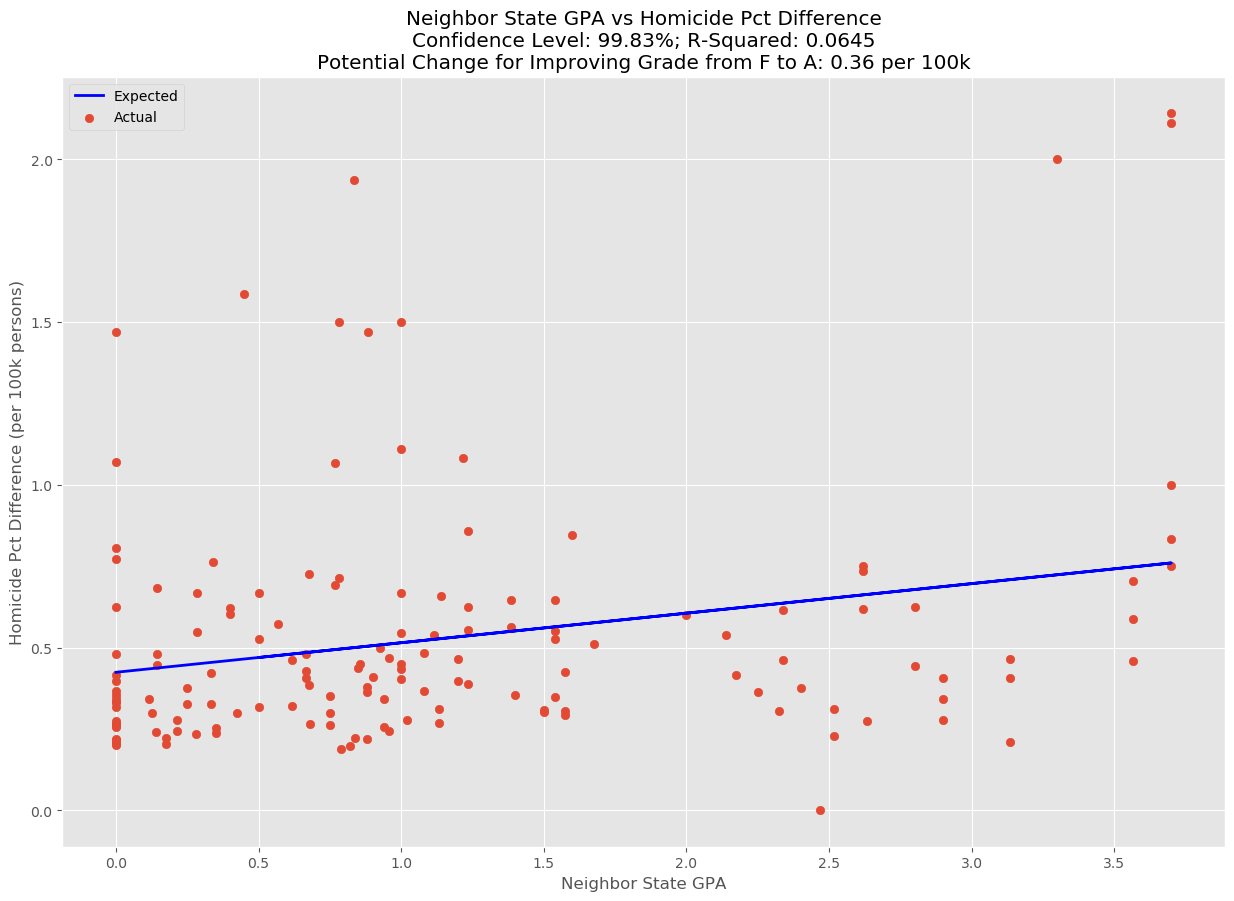

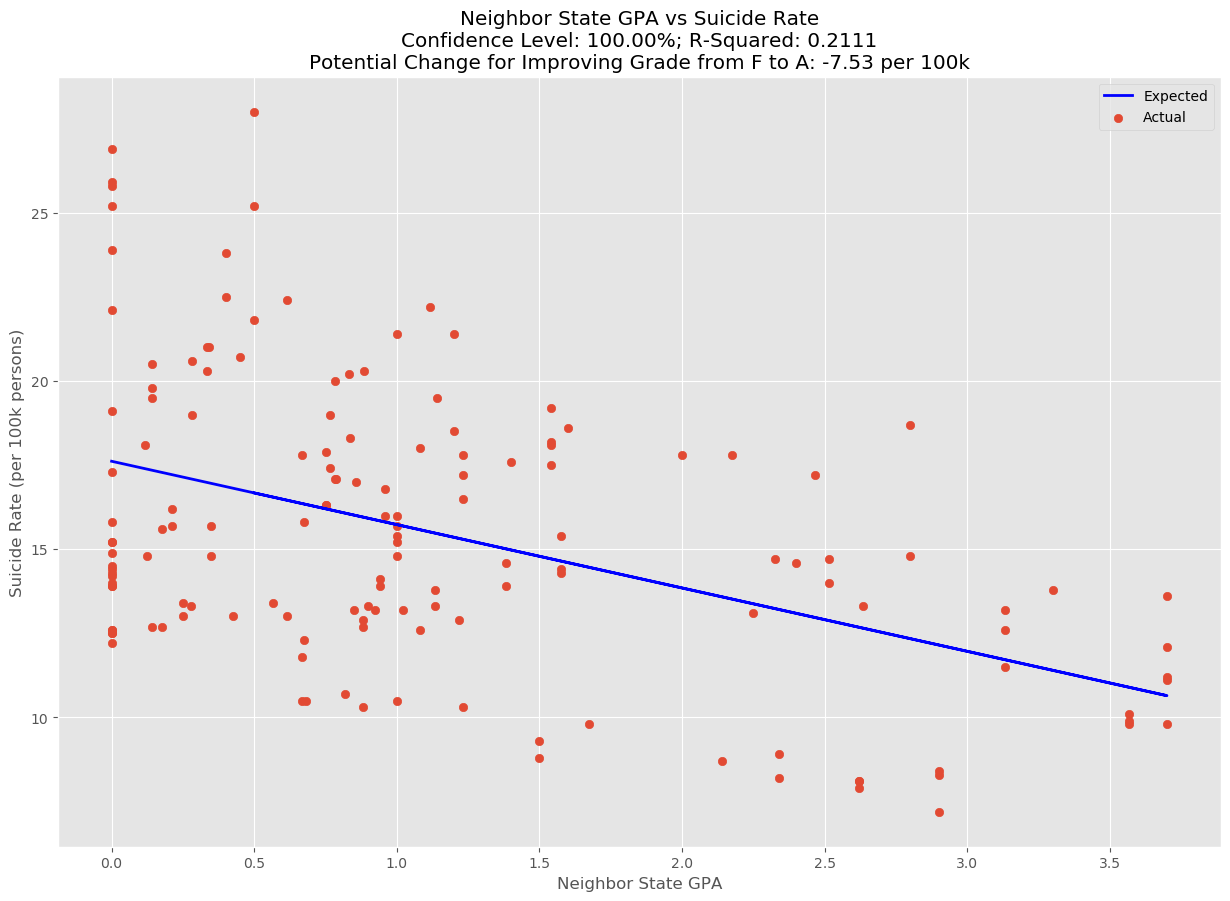

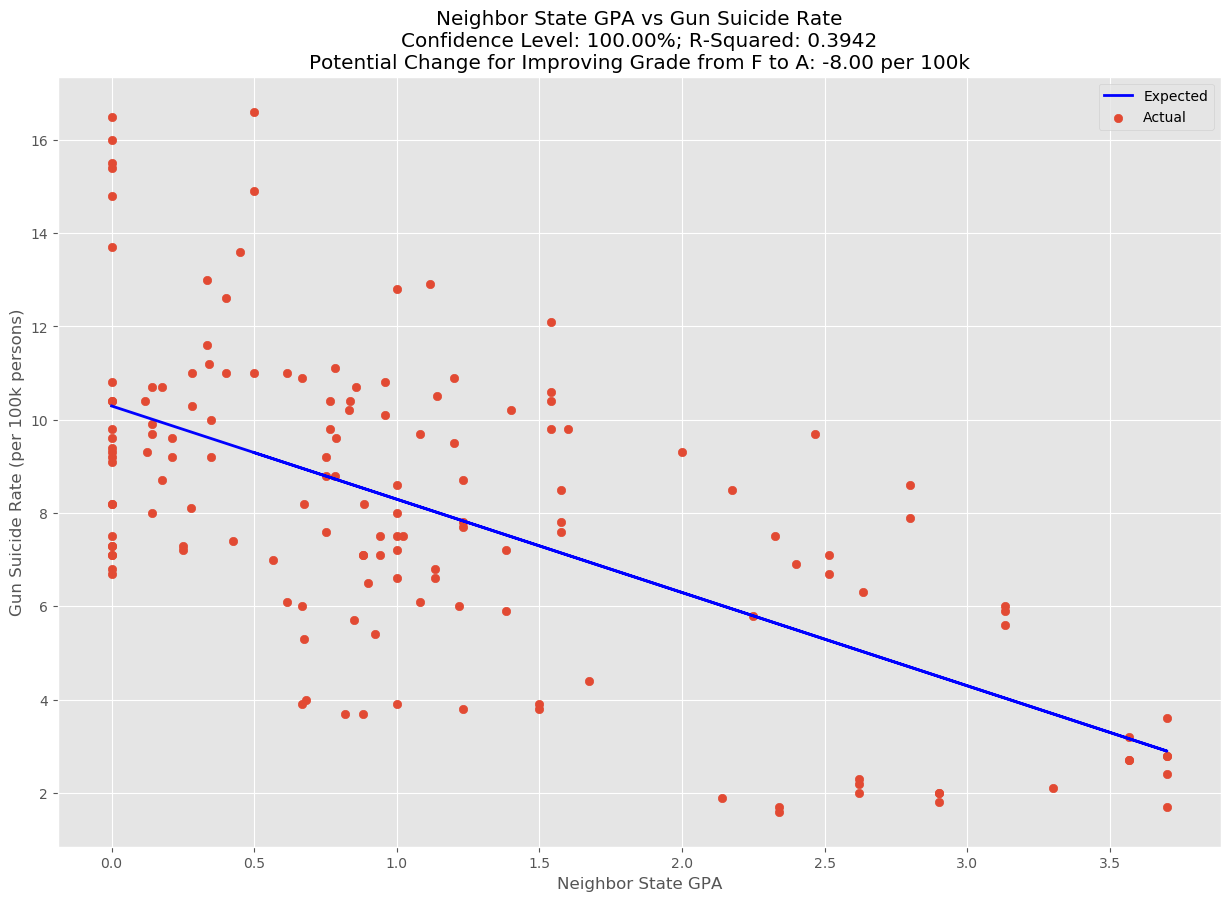

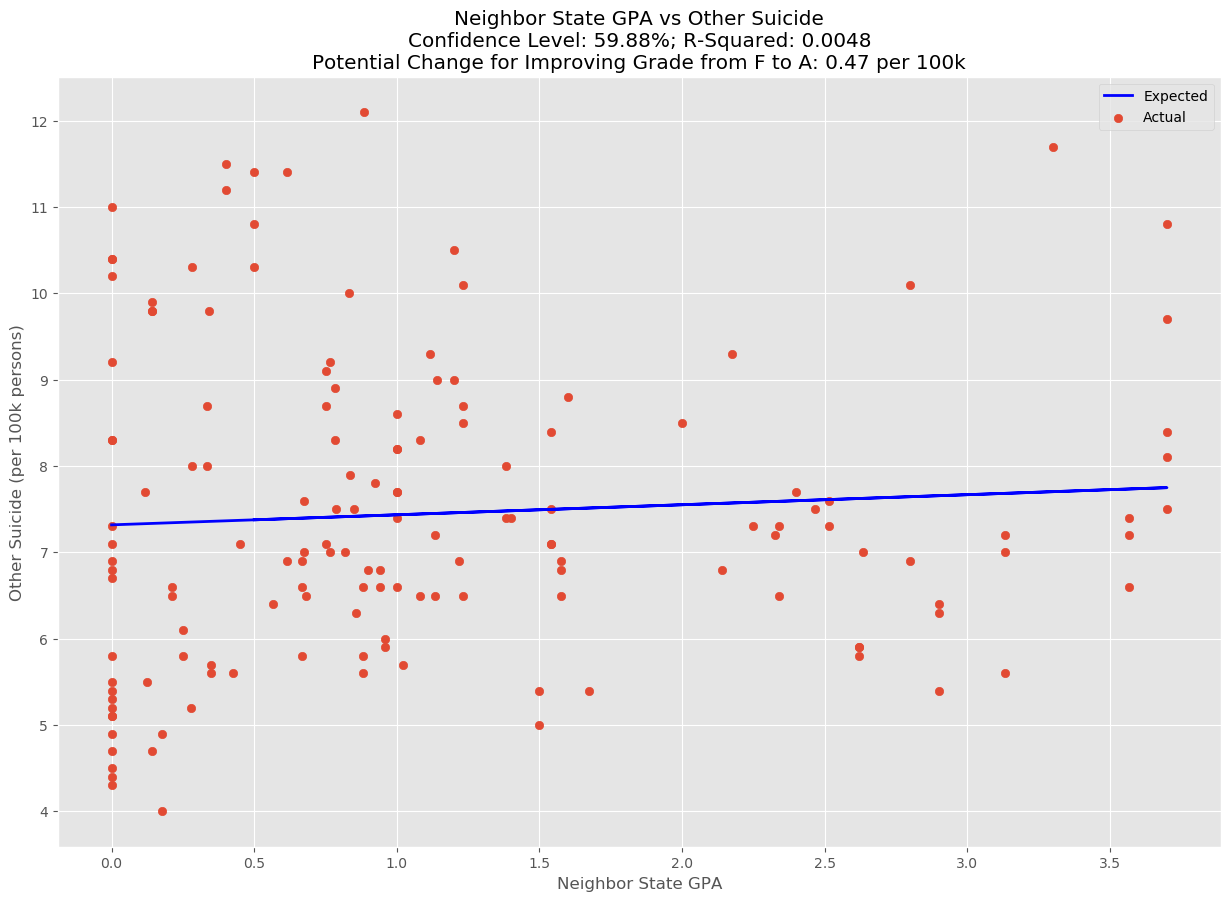

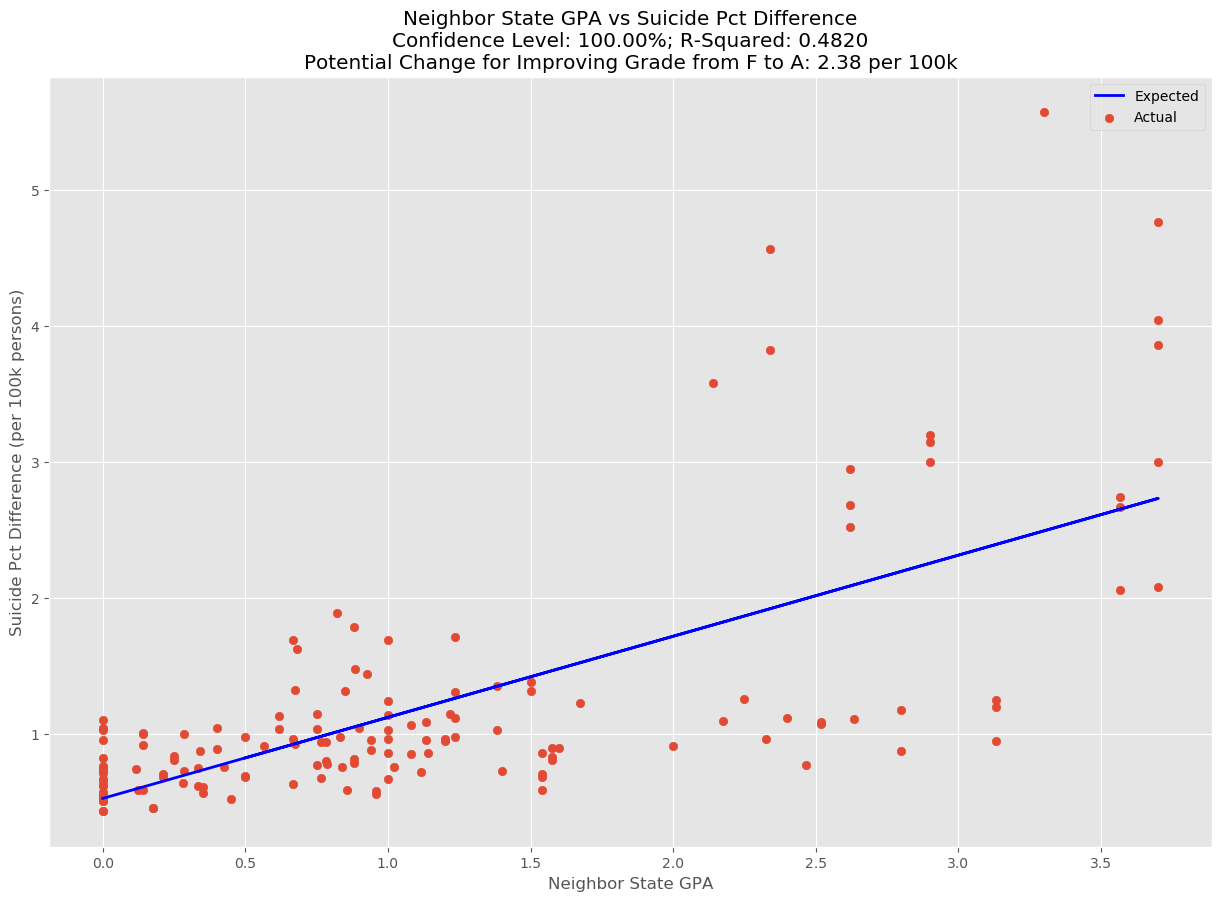

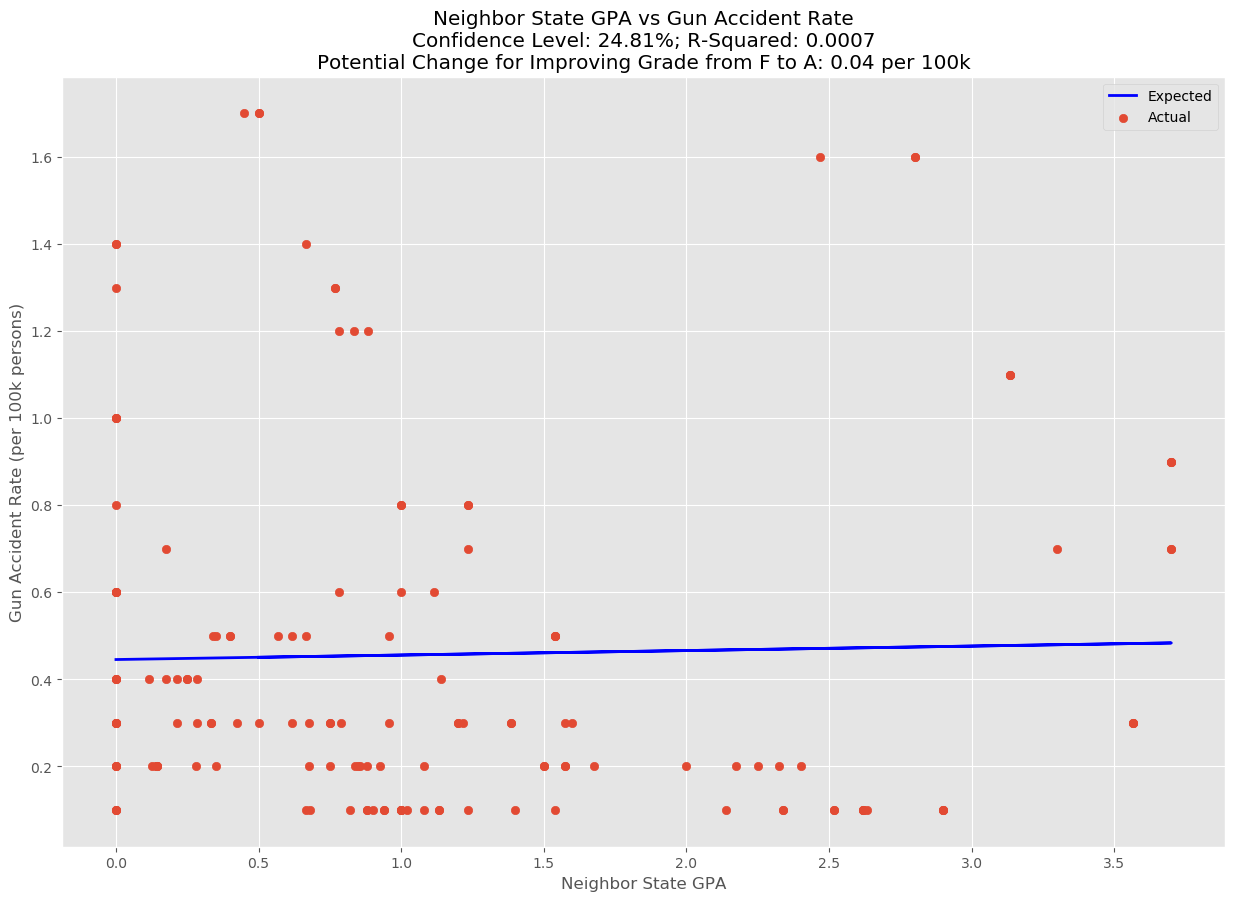

,Target,Predictor,R Squared,Intercept,Slope,P Value
0,Homicide_Rate,State_Grade,0.0673,5.8299,-0.4956,0.0014
1,Gun_Homicide_Rate,State_Grade,0.0583,4.2384,-0.3996,0.0029
2,Other_Homicide,State_Grade,0.0543,1.5915,-0.0960,0.0041
3,Homicide_Pct_Difference,State_Grade,0.0113,0.4949,0.0280,0.1960
4,Suicide_Rate,State_Grade,0.4413,17.8122,-2.0082,0.0000
5,Gun_Suicide_Rate,State_Grade,0.6448,10.2201,-1.8864,0.0000
6,Other_Suicide,State_Grade,0.0096,7.5920,-0.1218,0.2333
7,Suicide_Pct_Difference,State_Grade,0.5464,0.6584,0.4681,0.0000
8,Gun_Accident_Rate,State_Grade,0.0987,0.5637,-0.0916,0.0001
9,Homicide_Rate,Neighbor_State_GPA,0.1614,6.4335,-1.0410,0.0000


In [16]:
df = df[df.columns[3:]]

# Rename columns for regression model
for col in df.columns:
    df = df.rename(columns={col: col.replace(' ', '_')})

# Set target & predictor variables
targets = list(df.columns[1:-1])
predictors = ['State_Grade', 'Neighbor_State_GPA']

def regression(df, predictors, targets):
    # Run simple linear regressions for each predictor and each target
    results = [['Target', 'Predictor', 'R Squared', 'Intercept', 'Slope', 'P Value']]
    
    # Create display-friendly predictor variable names
    for predictor in predictors:
        Predictor = predictor.replace('_', ' ')
        
        # Create display-friendly target variable names
        for target in targets:
            Target = target.replace('_', ' ')

            # Create regression model as long as target & predictor are not same
            if predictor != target:
                # Fit & predict model
                f = f'{target}~{predictor}'
                model = smf.ols(formula=f, data=df).fit()
                y_pred = model.predict()

                # Append list of summary statistics to results
                results.append([target, 
                                predictor, 
                                np.round(model.rsquared, 4), 
                                np.round(model.params[0], 4), 
                                np.round(model.params[1], 4), 
                                np.round(model.pvalues[1], 4)])

                # Plot results
                plt.figure(figsize=(15, 10))
                plt.style.use('ggplot')
                plt.title(f'{Predictor} vs {Target}\n'
                          f'Confidence Level: {100*(1 - model.pvalues[1]):.2f}%; R-Squared: {model.rsquared:.4f}\n'
                          f'Potential Change for Improving Grade from F to A: {model.params[1]*4:.2f} per 100k')
                plt.xlabel(Predictor)
                plt.ylabel(f'{Target} (per 100k persons)')
                plt.scatter(df[predictor], df[target], marker='o', label='Actual')
                plt.plot(df[predictor], y_pred, color='b', lw=2, label='Expected')
                plt.legend()
                plt.show()

        # Create dataframe from results
        result_df = pd.DataFrame(results[1:],columns=results[0])

    return result_df

# Run regression for each predictor and target
# Return and display dataframe of results for each combination
regression(df, predictors, targets)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    # Calculate confidence interval for a range of data
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

warnings.filterwarnings('ignore')

def train_linreg(X, y, predictor, target, rand_state=123):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=rand_state)

    predictions_df = X_test[['State-Year']]
    X_train = X_train[[predictor]]
    X_test = X_test[[predictor]]
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)

    score = r2_score(y_test, y_hat_test)
    
    predictions_df['Predicted'] = np.round(y_hat_test, 1)
    predictions_df['Actual'] = y_test
    predictions_df = predictions_df.set_index('State-Year')
    
    return predictions_df, score

def results_distribution(X, y, predictor, target, n=100):
    scores = []
    Predictor = predictor.replace('_', ' ')
    Target = target.replace('_', ' ')
    
    print(f'\nCalculating Average Score for {Predictor} vs {Target}')
    for i in range(n):
        pred_df, score = train_linreg(X, y, predictor, target, rand_state=i)
        scores.append(score)

        if (100 * ((i+1) / n)) % 25 == 0:
            print(f'{int(100 * (i+1)/n)}% Complete')
    
    m, h = mean_confidence_interval(y, confidence=0.95)
    
    plt.figure(figsize=(20, 5))
    sns.distplot(scores)
    plt.title(f'{Predictor} vs {Target} R-Square Scores Distribution\nMean R-Squared: {np.mean(scores)*100:.2f}% (+/– {h:.2f}%)')
    plt.xlabel('R-Square Value')
    plt.ylabel('Frequency')
    plt.show()


Calculating Average Score for State Grade vs Suicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


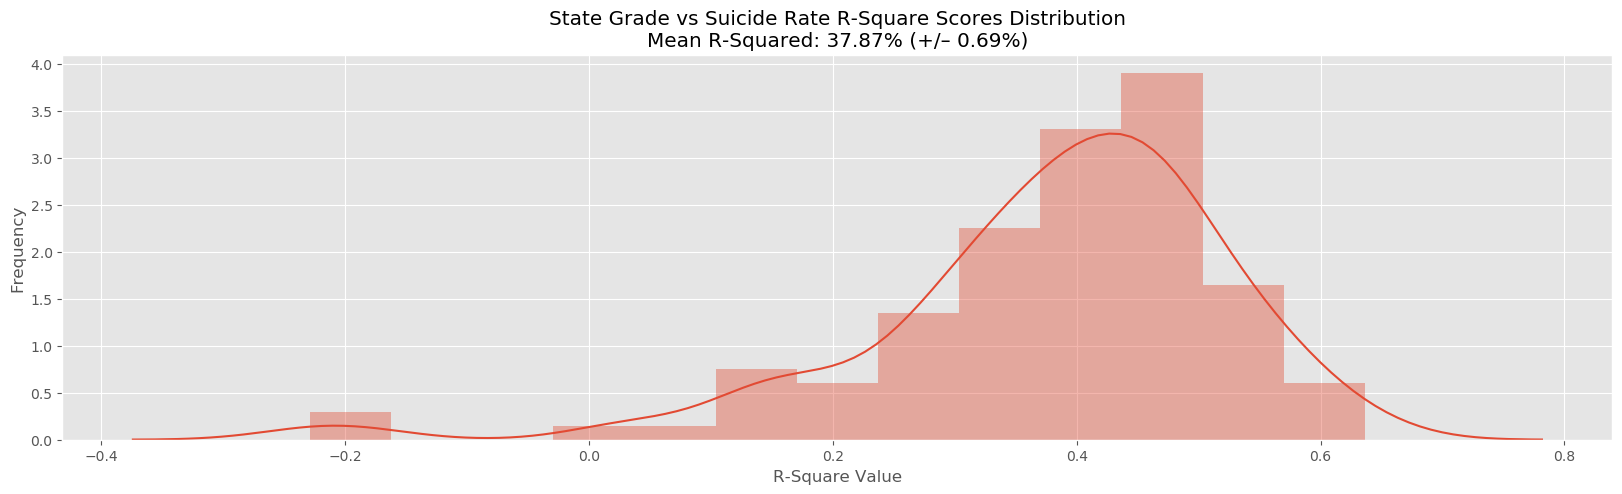


Calculating Average Score for State Grade vs Homicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


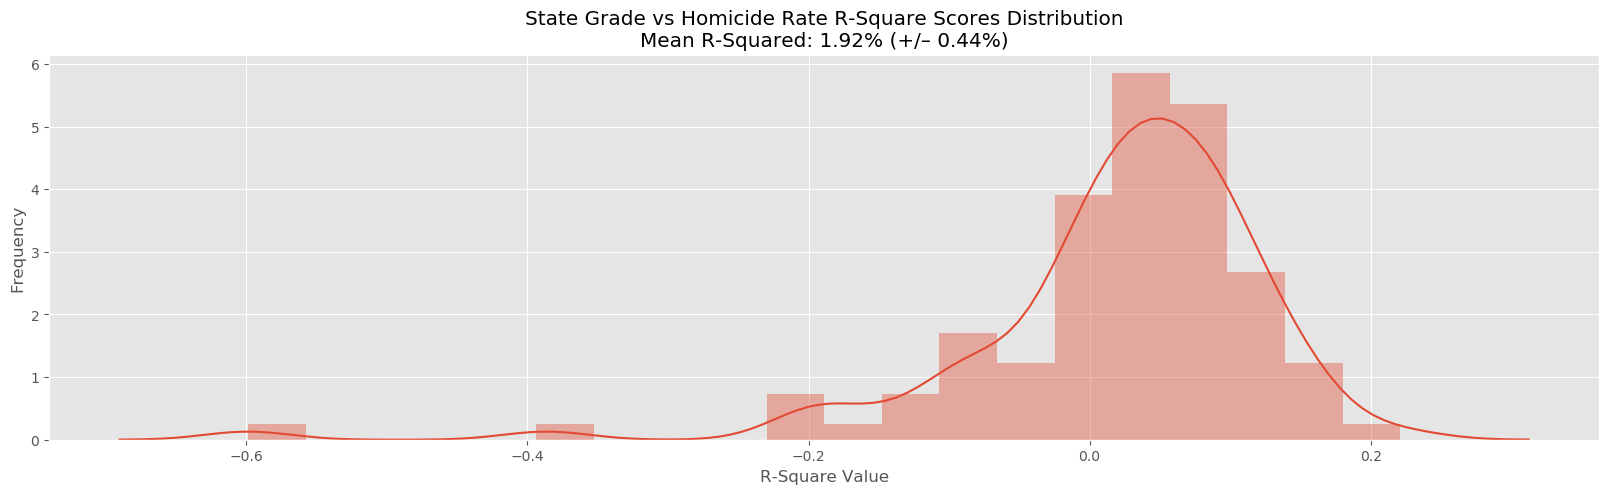


Calculating Average Score for Neighbor State GPA vs Suicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


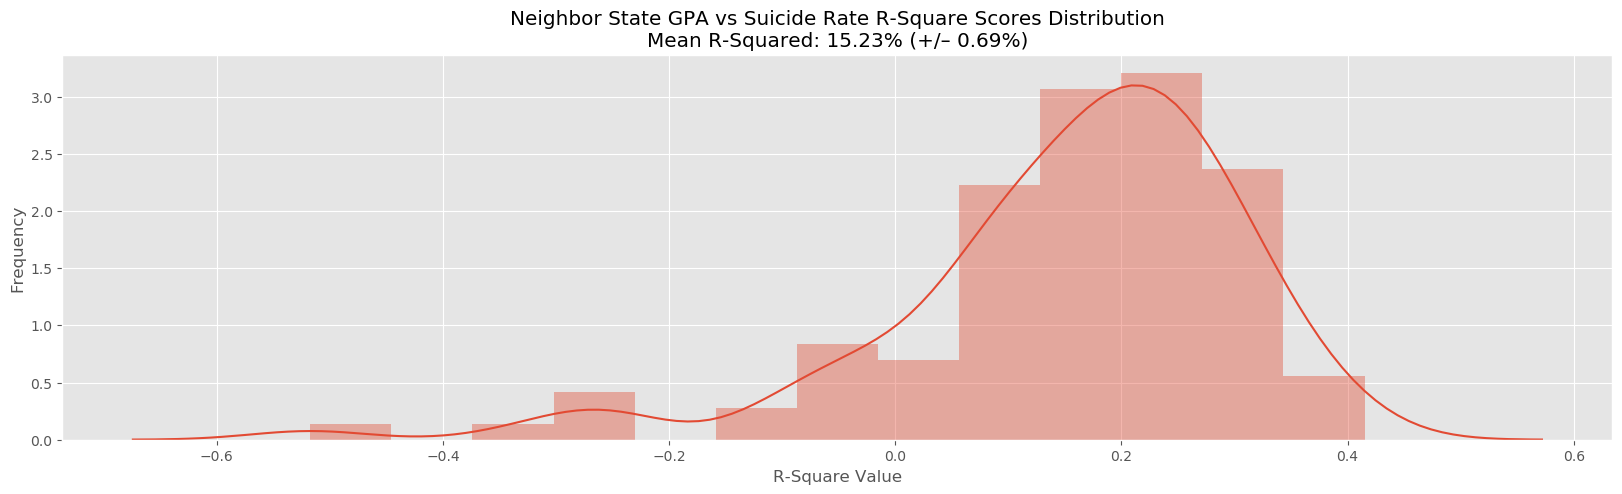


Calculating Average Score for Neighbor State GPA vs Homicide Rate
25% Complete
50% Complete
75% Complete
100% Complete


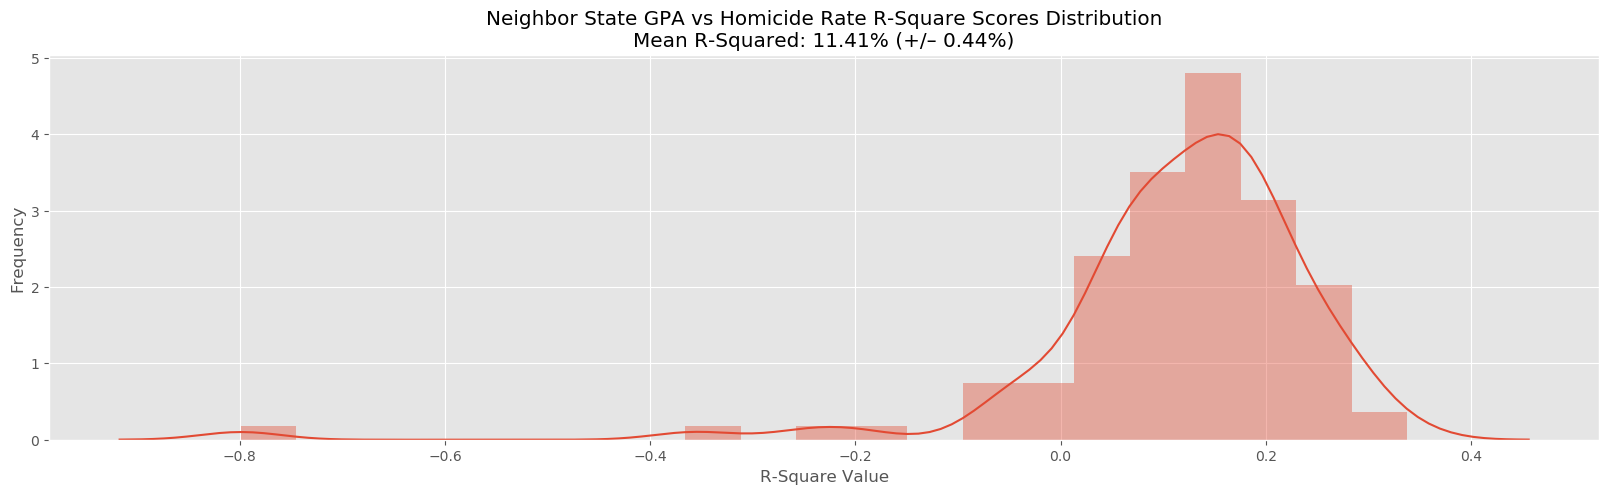

In [18]:
predictors = ['State_Grade', 'Neighbor_State_GPA']
targets = ['Suicide_Rate', 'Homicide_Rate']

for predictor in predictors:
    for target in targets:
        X = df.reset_index()[['State-Year', predictor]]
        y = df.reset_index()[target]
        results_distribution(X, y, predictor, target, 100)

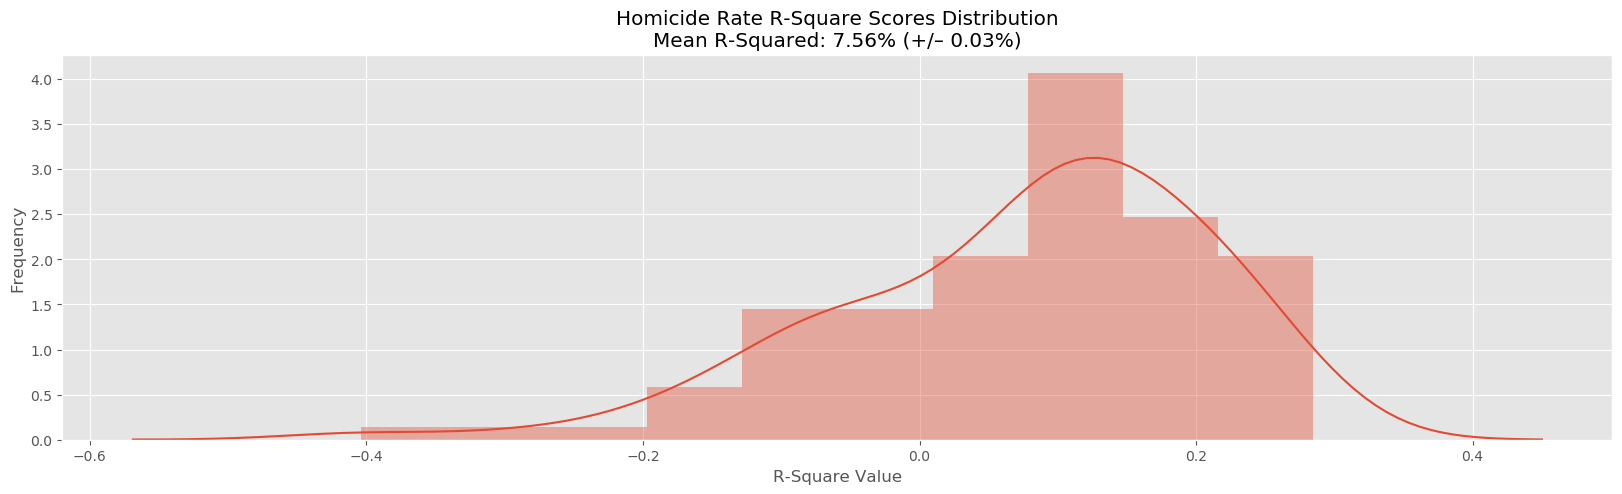

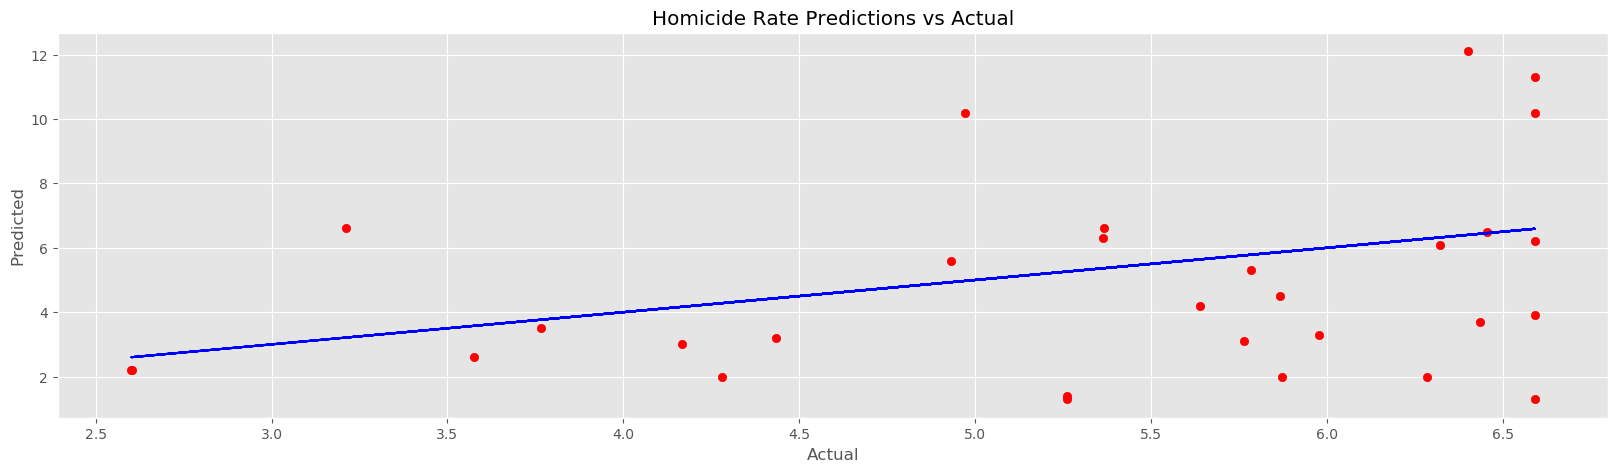

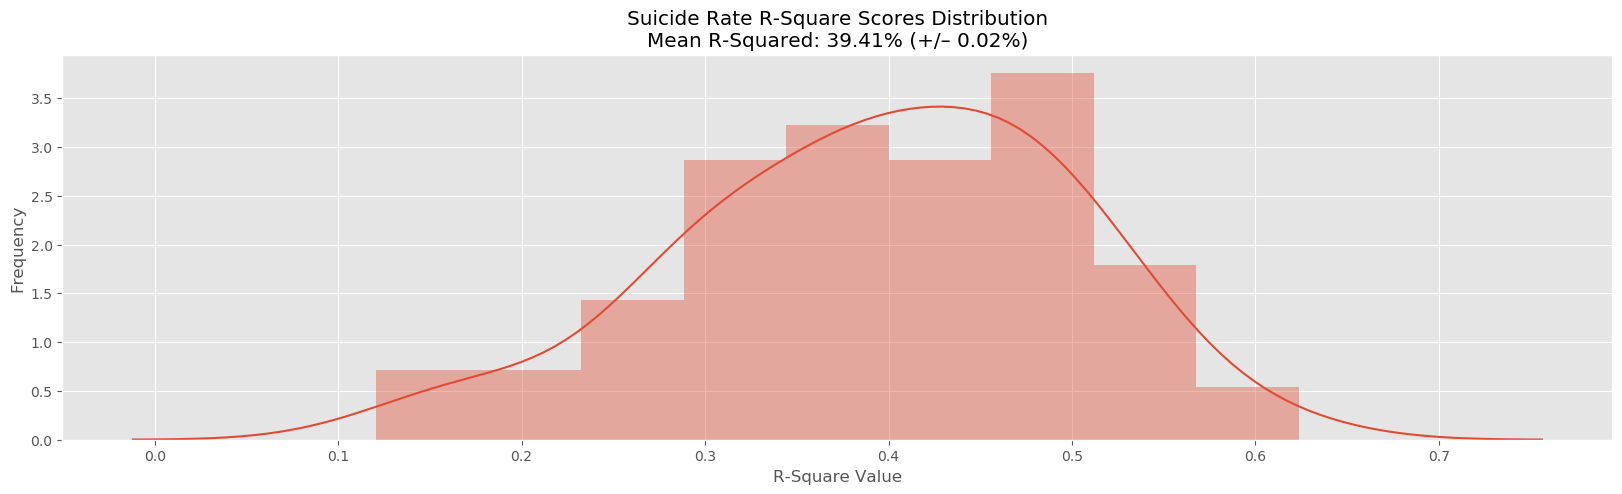

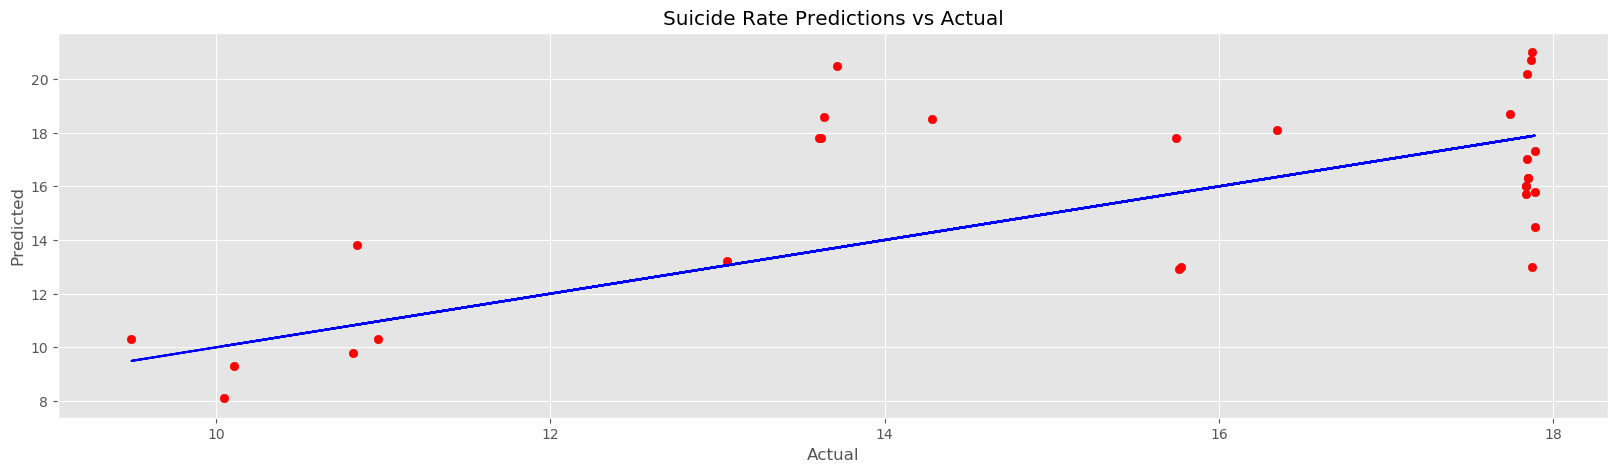

In [19]:
targets = ['Homicide_Rate', 'Suicide_Rate']
predictors = ['State_Grade', 'Neighbor_State_GPA']

for target in targets:
    X = df[predictors]
    y = df[target]
    
    scores = []
    
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)

        y_hat_test = linreg.predict(X_test)
        score = r2_score(y_test, y_hat_test)
        scores.append(score)
    
    Target = target.replace('_', ' ')
    
    m, h = mean_confidence_interval(scores)
    
    plt.figure(figsize=(20, 5))
    sns.distplot(scores)
    plt.title(f'{Target} R-Square Scores Distribution\nMean R-Squared: {np.mean(scores)*100:.2f}% (+/– {h:.2f}%)')
    plt.xlabel('R-Square Value')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(20, 5))
    plt.plot(y_hat_test, y_hat_test, color='b', label='Predicted')
    plt.scatter(y_hat_test, y_test, color='r', label='Actual')
    plt.title(f'{Target} Predictions vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [21]:
Ks=10
#determine best number of K
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsRegressor(n_neighbors = n).fit(X_train,y_train)
    yhat_KNN=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_KNN)

    
    std_acc[n-1]=np.std(yhat_KNN==y_test)/np.sqrt(yhat_KNN.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

ValueError: continuous is not supported

In [22]:
#Support Vector Machine
from sklearn import svm
clf_svm=svm.SVR(kernel='rbf')
clf_svm=clf_svm.fit(X_train, y_train)
yhat_SVM = clf_svm.predict(X_test)

In [24]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [27]:
f1_score(y_test, yhat_SVM, average='weighted')
jaccard_similarity_score(y_test, yhat_SVM)

ValueError: continuous is not supported

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score

# Initiate decision tree model
tree_pipe = Pipeline([('clf', DecisionTreeRegressor(random_state=123))])

# Create search grid
tree_grid = [{'clf__max_depth': list(range(1, 11, 2)), 
              'clf__min_samples_split': [i/100 for i in range(5, 96, 10)], 
              'clf__min_samples_leaf': list(range(1, 11, 2))}]

# Set accuracy measure
acc_meas = 'f1'

# Implement gridsearch
tree_gridsearch = GridSearchCV(estimator = tree_pipe, 
                               param_grid = tree_grid, 
                               scoring = acc_meas,
                               n_jobs=8,
                               cv=5, verbose = 1, return_train_score = True)

# Fit to training set with synthetic data
tree_gridsearch.fit(X_train, y_train)

# Predict new data & measure results
y_hat_test = tree_gridsearch.predict(X_test)
score = recall_score(y_test, y_hat_test)
prec_score = precision_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_hat_test)
cm_plot_labels = ['No Incidents', 'Mass Shooting']

plot_confusion_matrix(cm, cm_plot_labels, normalize=False)

print(f'Recall Score: {score*100:.2f}%')

# Save results
results = {'Pipeline': ['Decision Tree'], 
           'Recall Score': [score], 
           'Precision Score': [prec_score], 
           'F1 Score': [f1],
           'Parameters': [tree_gridsearch.best_params_]}

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: continuous is not supported